In [1]:
# Analysis libraries
import numpy as np
import pandas as pd
from scipy.stats import entropy, norm, gamma, linregress, pearsonr
from scipy.optimize import curve_fit
from scipy.special import gamma, hyp2f1
from scipy.stats import ks_2samp, kstest

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.ticker as tck
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import shapely 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import geopandas as gpd
from matplotlib.colors import TwoSlopeNorm

# Other libraries
import os
import sys
import re
import itertools
from tqdm import tqdm
import pickle

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2
from utils import *

In [55]:
sns.set(font='Avenir', font_scale=1.3, style='ticks')
fig_formats = ['.pdf', '.png', '.svg']
fig_dir = '../fig/'
supfig_dir = fig_dir+'supfig/'
os.makedirs(fig_dir, exist_ok=True)
os.makedirs(supfig_dir, exist_ok=True)
figsize_geo = (10,7.5)

colorSRF = '#7BC8F6'
colorDCM = '#000033'

palettename = 'coolwarm'
palette = sns.color_palette(palettename, 32)

golden = (1 + 5 ** 0.5) / 2
cms = 0.393701
figsize = (golden*8*cms,8*cms)

# Preprocessing data

### Metadata

In [3]:
# import metadata

filename_meta = '../data/woa_pisces_tarassd.tsv'
df = pd.read_csv(filename_meta, sep ='\t')
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="ESRI:54030")

# station 50 is missing!
# station 19 will be further removed because of bad data
gdf.tail()

,station,latitude,longitude,depth_category,depth_nominal,month,SSD,temp_woa,sal_woa,no3_woa,po4_woa,sioh4_woa,dco,dcu,dfe,dzn,geometry
129,205,72.4693,-71.8920,SUR,5,10,584.5,-0.89261,31.219290,1.793274,0.440587,3.355274,107.994,0.848,1.990,1.035,POINT (-71.892 72.469)
130,206,70.9618,-53.6030,SUR,5,10,564.5,2.43763,32.896900,1.785118,0.084252,2.914919,-999.000,-999.000,-999.000,-999.000,POINT (-53.603 70.962)
131,208,69.1136,-51.5086,SUR,5,10,508.0,2.93860,33.131413,1.630793,0.000000,3.127574,-999.000,-999.000,-999.000,-999.000,POINT (-51.509 69.114)
132,209,64.7127,-53.0106,SUR,5,10,531.5,2.51751,32.442013,3.216127,0.491307,0.668157,90.334,0.996,2.416,1.333,POINT (-53.011 64.713)
133,210,61.5442,-55.9865,SUR,5,10,535.0,5.20301,33.989799,3.419286,0.553510,2.276372,61.584,1.006,0.427,1.519,POINT (-55.986 61.544)


### Abundance data

In [4]:
# import abundances

filename_abund = '../data/Abundance.csv'
Abundances = pd.read_csv(filename_abund, index_col=0, header=0)
# since the column 019_SRF has a total abundance of 3, we remove it both from Abundances and gdf
Abundances = Abundances.drop(columns=['019_SRF'])
gdf = gdf.loc[~gdf['station'].isin([19])]
Normalized_Abundances = Abundances/Abundances.sum(axis=0)

Depths = {d: [c for c in Abundances.columns if c[-3:]==d] for d in ['SRF','DCM']}
Stations = np.unique([int(c.split('_')[0]) for c in Abundances[Abundances.sum(axis=1)>0].columns])
print (' Number of stations: {} \n Number of different OTUs: {}'.format(len(Stations), len(Abundances)))
print ('\n Number of stations SRF: {} \n Number of stations DCM: {}'.format(len(Depths['SRF']),len(Depths['DCM'])))

 Number of stations: 124 
 Number of different OTUs: 5830

 Number of stations SRF: 124 
 Number of stations DCM: 58


### Entropies and Regions

In [5]:
# add entropy measures to metadata

for depth in Depths:
    gdf['station_{}'.format(depth)] = gdf['station'].apply(lambda x: '{0:s}_{1:s}'.format(str(x).zfill(3),depth) if '{}_{}'.format(str(x).zfill(3), depth) in Abundances.columns else np.nan) 
    gdf['TotAbundance_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: Abundances[x].sum(axis=0) if x in Abundances.columns else None)
    gdf['Richness_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: len(Abundances.loc[Abundances[x]>0]) if x in Abundances.columns else None)
    gdf['Shannon_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: entropy(Normalized_Abundances.loc[:,x]) if x in Abundances.columns else None)
    gdf['Evenness_{}'.format(depth)] = gdf['Shannon_{}'.format(depth)]/np.log(gdf['Richness_{}'.format(depth)])
    
# add regions to metadata
gdf['region'] = gdf['latitude'].apply(lambda x : return_geo(x))



### Preliminary fits

We load the fits obtained by fitting Equation 1 of the paper to the data. Equation 1 reads:
$$
P(n) = \theta\left(\alpha,\beta, r \right) \frac{\Gamma (\beta +1) \Gamma (n+\alpha )}{\Gamma (\alpha ) \Gamma (n+\beta +1)} e^{-r n}
$$

where we have introduced the parameters $\alpha=\chi/b$, $\beta=\mu/d$, and $r=\log{b/d}$, whilst $\Gamma(\cdot)$ is the Gamma function and $\theta\left(\alpha,\beta, r \right)$ is a normalization factor that ensures $\sum_{n\geq1}P(n)=1$. 

In [6]:
# import fits

filename_fits = '../data/fit_completi.csv'
fits = pd.read_csv(filename_fits, index_col=0)

# rename columns
fits = fits.rename(columns={'vec_estimated_k':'beta', 'vec_estimated_l':'alpha', 'vec_estimated_r':'r'})#.reset_index(inplace=True)
fits['station_number'] = fits['station'].apply(lambda x: int(x.split('_')[0]))
fits['lambda'] = 1 - fits.loc[:,'alpha'] + fits.loc[:,'beta']
fits = fits.set_index('station')

# add fits to metadata
for depth in Depths:
    gdf['lambda_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: fits.loc[x,'lambda'] if x in fits.index else None)
    gdf['alpha_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: fits.loc[x,'alpha'] if x in fits.index else None)
    gdf['beta_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: fits.loc[x,'beta'] if x in fits.index else None)
    gdf['r_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: fits.loc[x,'r'] if x in fits.index else None)
    # station 50 is missing!
    
# remove stations with no fit (where r is not nan)
SRF = gdf[gdf['r_SRF'].notna()]
DCM = gdf[gdf['r_DCM'].notna()]
# remove lambda_DCM	alpha_DCM	beta_DCM	r_DCM from SRF and viceversa
SRF = SRF.drop(columns=['lambda_DCM','alpha_DCM','beta_DCM','r_DCM', 'station_DCM', 'TotAbundance_DCM',	'Richness_DCM',	'Shannon_DCM',	'Evenness_DCM'])
DCM = DCM.drop(columns=['lambda_SRF','alpha_SRF','beta_SRF','r_SRF', 'station_SRF', 'TotAbundance_SRF',	'Richness_SRF',	'Shannon_SRF',	'Evenness_SRF'])
DCM['depth_category'] = 'DCM'
    
print('Number of stations SRF: {} \nNumber of stations DCM: {}'.format(len(SRF),len(DCM)))
print('Number of stations with r=0 SRF: {} \nNumber of stations with r=0 DCM: {}'.format(len(SRF[SRF['r_SRF']==0]),len(DCM[DCM['r_DCM']==0])))


Number of stations SRF: 123 
Number of stations DCM: 58
Number of stations with r=0 SRF: 96 
Number of stations with r=0 DCM: 34


In [7]:
print((96+34)/(123+58), 96+34, 123+58)

0.7182320441988951 130 181


### Power law fits

In [8]:
# power law fit to data

lambda_dict, pval_dict = {}, {}
for col in Abundances.columns:
    data = Abundances[col].values
    station = col
    rho, pvalue = maximum_likelihood_exponent(data)
    lambda_dict[station] = rho + 1
    pval_dict[station] = pvalue

# add power law fits to metadata
SRF['lambda_PL'] = SRF['station_SRF'].apply(lambda x: lambda_dict[x] if x in lambda_dict.keys() else None)
DCM['lambda_PL'] = DCM['station_DCM'].apply(lambda x: lambda_dict[x] if x in lambda_dict.keys() else None)

## Undersampling

### From power law fits
If the metacommunity SAD follows a power law, then the local SADs follow a power law as well. In particular, we suppose that the metacommunity SADs follow a power law with exponent $\rho_j$:
$$
P(n) = \frac{1}{\zeta (\rho +1)} n^{-1-\rho}
$$

We exploit the limit $p\to0$, where $p$ is the sampling effort, to obtain a relation between the sample richness $S_{loc}$ and abundance $N_{loc}$ with the total richness $S$ and abundance $N$ of the metacommunity. This relation reads:
$$
S_{loc} = \underbrace{-\frac{\Gamma (-\rho )}{\zeta (\rho +1)} \frac{S}{(N)^{\rho}}}_{K} N_{loc}^{\rho}
$$
We want to test the hypothesis that all the local SADs are sampled from the same meta-community. This means that $K$ and $\rho$ the same for all the local SADs. We can test this hypothesis by choosing a  station as a reference station and predict the richness of the other stations. We can then compare the predicted richness with the observed richness:
$$
S_{loc} = S_{ref} \left(\frac{N_{loc}}{N_{ref}}\right)^{\rho}
$$

$\rho$ is the exponent of the metacommunity. Here, several options are possible:
1. We can use the exponent of the reference station as the exponent of the metacommunity.
2. We can use the average or the median of the exponents of all the stations as the exponent of the metacommunity.
3. We can use the mode of the exponents of all the stations as the exponent of the metacommunity.

In [9]:
# rho should be the exponent of the metacommunity.
which = '173_SRF' # it can be either the reference station (173_SRF), the mode, the mean, the median.
ref_station = 173

if which == '173_SRF':
    rho_PL = SRF.loc[SRF['station_SRF']==which,'lambda_PL'].values[0] - 1
elif which == 'mode':
    rho_PL = mode_with_binning(SRF['lambda_PL'], bins=5) - 1
elif which == 'mean':
    rho_PL = np.round(SRF['lambda_PL'].mean() - 1, 2)
elif which == 'median':
    rho_PL = np.round(SRF['lambda_PL'].median() - 1, 2)
else:
    print('Error: which should be either 173_SRF, mode, mean or median')

print('rho = {}'.format(rho_PL))

N_ref, S_ref = SRF.loc[SRF['station']==ref_station,['TotAbundance_SRF', 'Richness_SRF']].values[0]
print('N_ref = {}, S_ref = {}'.format(N_ref, S_ref))
SRF['Spred_PL'] = SRF.loc[:,'TotAbundance_SRF'].apply(lambda N_loc: (N_loc/N_ref)**(rho_PL)*S_ref)
SRF['DeltaS_PL'] = (SRF['Spred_PL'] - SRF['Richness_SRF'])/SRF['Richness_SRF']
SRF['pval_PL'] = SRF.loc[:,['Richness_SRF', 'Spred_PL']].apply(lambda x: two_tailed_pvalue(x[0], x[1], np.sqrt(x[1])), axis=1)

DCM['Spred_PL'] = DCM.loc[:,'TotAbundance_DCM'].apply(lambda N_loc: (N_loc/N_ref)**(rho_PL)*S_ref)
DCM['DeltaS_PL'] = (DCM['Spred_PL'] - DCM['Richness_DCM'])/DCM['Richness_DCM']
DCM['pval_PL'] = DCM.loc[:,['Richness_DCM', 'Spred_PL']].apply(lambda x: two_tailed_pvalue(x[0], x[1], np.sqrt(x[1])), axis=1)

print('Percentage of stations with pval_PL < 0.05 SRF: {0:1.2f} \nPercentage of stations with pval_PL < 0.05 DCM: {1:1.2f}'.format(len(SRF[SRF['pval_PL']<0.05])/len(SRF)*100, len(DCM[DCM['pval_PL']<0.05])/len(DCM)*100))

rho = 0.654193201801047
N_ref = 312215.0, S_ref = 422.0
Percentage of stations with pval_PL < 0.05 SRF: 95.12 
Percentage of stations with pval_PL < 0.05 DCM: 94.83


### From asymptotic behaviour of original fits

We follow the same procedure outlined for the power law fits. We use the asymptotic behaviour of the original fits to predict the richness of the local SADs. The asymptotic behaviour of the original fits is given by the same equaiton, where now $\rho=\lambda-1$ is the asymptotic exponent of the original fits. Since $\rho$ is the exponent of the metacommunity, we have several options:
1. We can use the exponent of the reference station as the exponent of the metacommunity.
2. We can use the average or the median of the exponents of all the stations as the exponent of the metacommunity.
3. We can use the mode of the exponents of all the stations as the exponent of the metacommunity. The mode is defined after a binning procedure. We bin the exponents in bins of width 0.1 and we take the mode of each bin.

In [10]:
# rho should be the exponent of the metacommunity.
which = '173_SRF' # it can be either the reference station (173_SRF), the mode, the mean, the median.
ref_station = 173

if which == '173_SRF':
    rho_asympt = SRF.loc[SRF['station']==ref_station,'lambda_SRF'].values[0] - 1
elif which == 'mode':
    rho_asympt = mode_with_binning(SRF['lambda_SRF'], bins=5) - 1
elif which == 'mean':
    rho_asympt = np.round(SRF['lambda_SRF'].mean() - 1, 2)
elif which == 'median':
    rho_asympt = np.round(SRF['lambda_SRF'].median() - 1, 2)
else:
    print('Error: which should be either 173_SRF, mode, mean or median')

print('rho = {}'.format(rho_asympt))

N_ref, S_ref = SRF.loc[SRF['station']==ref_station,['TotAbundance_SRF', 'Richness_SRF']].values[0]
print('N_ref = {}, S_ref = {}'.format(N_ref, S_ref))
SRF['Spred_asympt'] = SRF.loc[:,'TotAbundance_SRF'].apply(lambda N_loc: (N_loc/N_ref)**(rho_asympt)*S_ref)
SRF['DeltaS_asympt'] = (SRF['Spred_asympt'] - SRF['Richness_SRF'])/SRF['Richness_SRF']
SRF['pval_asympt'] = SRF.loc[:,['Richness_SRF', 'Spred_asympt']].apply(lambda x: two_tailed_pvalue(x[0], x[1], np.sqrt(x[1])), axis=1)

DCM['Spred_asympt'] = DCM.loc[:,'TotAbundance_DCM'].apply(lambda N_loc: (N_loc/N_ref)**(rho_asympt)*S_ref)
DCM['DeltaS_asympt'] = (DCM['Spred_asympt'] - DCM['Richness_DCM'])/DCM['Richness_DCM']
DCM['pval_asympt'] = DCM.loc[:,['Richness_DCM', 'Spred_asympt']].apply(lambda x: two_tailed_pvalue(x[0], x[1], np.sqrt(x[1])), axis=1)

print('Percentage of stations with pval_asympt < 0.05 SRF: {0:1.2f} \nPercentage of stations with pval_asympt < 0.05 DCM: {1:1.2f}'.format(len(SRF[SRF['pval_asympt']<0.05])/len(SRF)*100, len(DCM[DCM['pval_asympt']<0.05])/len(DCM)*100))

rho = 0.485529379081201
N_ref = 312215.0, S_ref = 422.0
Percentage of stations with pval_asympt < 0.05 SRF: 83.74 
Percentage of stations with pval_asympt < 0.05 DCM: 93.10


### From original fits

In [11]:
filename_originalDS = '../data/Sloc_Spred_173_SRF_BHM.csv'
dfS = pd.read_csv(filename_originalDS, index_col=0)
dfS['DeltaS']=(dfS['Spred']-dfS['Sobs'])/dfS['Sobs']

# splitting the dataset in two (SRF and DCM)
dfS_SRF = dfS.loc[[st for st in dfS.index if st[-3:] == 'SRF'],:]
dfS_DCM = dfS.loc[ [st for st in dfS.index if st[-3:] == 'DCM'],:]

# adding Spred to SRF and DCM metadata
SRF['Spred_original'] = SRF['station'].apply(lambda x: dfS_SRF.loc['{:03}_SRF'.format(x),'Spred'])
SRF['DeltaS_original'] = SRF['station'].apply(lambda x: dfS_SRF.loc['{:03}_SRF'.format(x),'DeltaS'])
SRF['pval_original'] = SRF.loc[:,['Richness_SRF', 'Spred_original']].apply(lambda x: two_tailed_pvalue(x[0], x[1], np.sqrt(x[1])), axis=1)

DCM['Spred_original'] = DCM['station'].apply(lambda x: dfS_DCM.loc['{:03}_DCM'.format(x),'Spred'])
DCM['DeltaS_original'] = DCM['station'].apply(lambda x: dfS_DCM.loc['{:03}_DCM'.format(x),'DeltaS'])
DCM['pval_original'] = DCM.loc[:,['Richness_DCM', 'Spred_original']].apply(lambda x: two_tailed_pvalue(x[0], x[1], np.sqrt(x[1])), axis=1)

print('Percentage of stations with pval_original < 0.05 SRF: {0:1.2f} \nPercentage of stations with pval_original < 0.05 DCM: {1:1.2f}'.format(len(SRF[SRF['pval_original']<0.05])/len(SRF)*100, len(DCM[DCM['pval_original']<0.05])/len(DCM)*100))

dfS_SRF.head()

Percentage of stations with pval_original < 0.05 SRF: 73.98 
Percentage of stations with pval_original < 0.05 DCM: 84.48


,Sobs,Spred,DeltaS
station,,,
158_SRF,47,54,0.148936
188_SRF,516,608,0.178295
194_SRF,319,348,0.090909
206_SRF,300,447,0.490000
191_SRF,245,366,0.493878


## Undersampling references

In [12]:
ref_stations = ['173_SRF', '188_SRF', '205_SRF', '086_SRF', '201_DCM', '180_DCM']
Srefs, Nrefs, lambdarefs = [], [], []
for ref_station in ref_stations:
    if ref_station[-3:] == 'SRF':
        N_ref, S_ref, lambda_ref = SRF.loc[SRF['station_SRF']==ref_station,['TotAbundance_SRF', 'Richness_SRF', 'lambda_SRF']].values[0]
    elif ref_station[-3:] == 'DCM':
        N_ref, S_ref, lambda_ref = DCM.loc[DCM['station_DCM']==ref_station,['TotAbundance_DCM', 'Richness_DCM', 'lambda_DCM']].values[0]
    Srefs.append(S_ref)
    Nrefs.append(N_ref)
    lambdarefs.append(lambda_ref)
    
print('Srefs: {}'.format(Srefs))
print('Nrefs: {}'.format(Nrefs))
print('lambdarefs: {}'.format(lambdarefs))

# indexes of both SRF and DCM stations
SRF_indexes = list(SRF['station_SRF'].values)
DCM_indexes = list(DCM['station_DCM'].values)
indexes = SRF_indexes + DCM_indexes

df_DS = pd.DataFrame(index=indexes, columns=['depth'])
df_DS['depth'] = df_DS.index.map(lambda x: x[-3:])
df_DS['number_station'] = df_DS.index.map(lambda x: int(x.split('_')[0]))

for ref_station, Sref, Nref, lambda_ref in zip(ref_stations, Srefs, Nrefs, lambdarefs):
    # Nloc
    Nloc_SRF = SRF.loc[:,'TotAbundance_SRF'].values
    Nloc_DCM = DCM.loc[:,'TotAbundance_DCM'].values
    Nloc = np.concatenate((Nloc_SRF, Nloc_DCM))
    # Sloc
    Sloc_SRF = SRF.loc[:,'Richness_SRF'].values
    Sloc_DCM = DCM.loc[:,'Richness_DCM'].values
    Sloc = np.concatenate((Sloc_SRF, Sloc_DCM))
    # Sp
    Sp = Sref*(Nloc/Nref)**(lambda_ref-1)
    # DeltaS
    DeltaS = (Sp - Sloc)/Sloc
    df_DS['{} {}'.format(ref_station.split('_')[0], ref_station.split('_')[1])] = DeltaS
    
df_DS.head()

Srefs: [422.0, 516.0, 541.0, 568.0, 577.0, 372.0]
Nrefs: [312215.0, 851578.0, 1558339.0, 358503.0, 615428.0, 1386717.0]
lambdarefs: [1.485529379081201, 1.5111895549551453, 1.478732998243447, 1.813298837875406, 1.5625754474696807, 1.461405253444677]


,depth,number_station,173 SRF,188 SRF,205 SRF,086 SRF,201 DCM,180 DCM
007_SRF,SRF,7,-0.261541,-0.508555,-0.550295,-0.737356,-0.482394,-0.642128
008_SRF,SRF,8,-0.299036,-0.559828,-0.566511,-0.881270,-0.587297,-0.641235
010_SRF,SRF,10,-0.474636,-0.681975,-0.671935,-0.944293,-0.722932,-0.721679
011_SRF,SRF,11,-0.739873,-0.837457,-0.838923,-0.958630,-0.849099,-0.866244
012_SRF,SRF,12,-0.305278,-0.571232,-0.568398,-0.905662,-0.611680,-0.638599


## Correlations

In [13]:
# correlation analyisis with the asymptotic fits

columns_numbers = [col for col in SRF.columns if SRF[col].dtype in [np.float64, np.int64]]
SRF['absolute_latitude'] = np.abs(SRF['latitude'])
SRF['absolute_DS_asympt'] = np.abs(SRF['DeltaS_asympt'])
columns_numbers = ['absolute_latitude', 'temp_woa', 'SSD', 'sal_woa', 'no3_woa', 'po4_woa', 'sioh4_woa',
                   'dco', 'dcu', 'dfe', 'dzn',
                   'TotAbundance_SRF', 'Richness_SRF', 'Evenness_SRF','DeltaS_asympt', 'absolute_DS_asympt']
print(columns_numbers)

method = 'spearman'

# compute correlation matrix and plot it
corr = SRF.loc[:,columns_numbers].corr(method)

dictionary = {'Richness_SRF':'Richness', 'absolute_latitude':'Latitude', 'longitude':'Longitude', 
              'TotAbundance_SRF':'Abundance', 'Evenness_SRF':'Evenness', 'temp_woa':'Temperature', 'DeltaS_asympt':r'$\Delta$S',
              'sal_woa': 'Salinity', 'no3_woa': 'NO$_3$', 'po4_woa': 'PO$_4$', 'sioh4_woa': 'Si(OH)$_4$',
              'dco': 'CO', 'dcu': 'Cu', 'dfe': 'Fe', 'dzn': 'Zn', 'SSD': 'Solar light', 'absolute_DS_asympt': r'$|\Delta$S|'
              }

corr.rename(columns=dictionary,
           index=dictionary,
            inplace=True
           )

pvalues_corr = calculate_pvalues(SRF.loc[:,columns_numbers], method=method)    

pvalues_corr

['absolute_latitude', 'temp_woa', 'SSD', 'sal_woa', 'no3_woa', 'po4_woa', 'sioh4_woa', 'dco', 'dcu', 'dfe', 'dzn', 'TotAbundance_SRF', 'Richness_SRF', 'Evenness_SRF', 'DeltaS_asympt', 'absolute_DS_asympt']


,absolute_latitude,temp_woa,SSD,sal_woa,no3_woa,po4_woa,sioh4_woa,dco,dcu,dfe,dzn,TotAbundance_SRF,Richness_SRF,Evenness_SRF,DeltaS_asympt,absolute_DS_asympt
absolute_latitude,0.0,0.0,0.079467,0.017845,0.0747,0.166795,0.646386,0.001875,0.002645,0.015821,0.000002,0.000019,0.016111,0.0,0.0,0.137672
temp_woa,0.0,0.0,0.013536,0.000312,0.00008,0.000195,0.016828,0.033591,0.002209,0.387188,0.000004,0.000001,0.001008,0.0,0.0,0.238113
SSD,0.079467,0.013536,0.0,0.0,0.004994,0.0,0.011076,0.852744,0.953379,0.156285,0.919801,0.024697,0.589778,0.000258,0.000054,0.204979
sal_woa,0.017845,0.000312,0.0,0.0,0.008011,0.0,0.0,0.486244,0.007458,0.129743,0.043693,0.0,0.000049,0.0,0.0,0.080456
no3_woa,0.0747,0.00008,0.004994,0.008011,0.0,0.0,0.000014,0.389942,0.148914,0.001519,0.190901,0.000005,0.000137,0.000025,0.008874,0.099143
po4_woa,0.166795,0.000195,0.0,0.0,0.0,0.0,0.0,0.455759,0.632754,0.003083,0.992966,0.0,0.000008,0.000002,0.000045,0.027338
sioh4_woa,0.646386,0.016828,0.011076,0.0,0.000014,0.0,0.0,0.312381,0.980799,0.883709,0.905804,0.000004,0.000039,0.001157,0.023308,0.610852
dco,0.001875,0.033591,0.852744,0.486244,0.389942,0.455759,0.312381,0.0,0.0,0.0,0.0,0.027289,0.049345,0.247305,0.260168,0.043177
dcu,0.002645,0.002209,0.953379,0.007458,0.148914,0.632754,0.980799,0.0,0.0,0.0,0.0,0.951733,0.528521,0.528887,0.506911,0.85774
dfe,0.015821,0.387188,0.156285,0.129743,0.001519,0.003083,0.883709,0.0,0.0,0.0,0.000001,0.654827,0.43346,0.487865,0.720654,0.009966


## Heaps' law for power law

In [14]:
# generate random numbers from power law distribution with inverse transform sampling
alpha = 0.5
S = 1000
species = range(S)

u = 1-np.random.uniform(size=S)
x = np.array((1-u/alpha)**(-1./(alpha)), dtype=int)
N = np.sum(x)

# subsamples of size n = p*N
ps = np.logspace(-7, -1, 7)
samples = []

In [15]:
# read or generate samples
which = 'read'

if which == 'generate':
    for p in ps:
        Np = int(N * p)
        subsample = np.zeros(Np, dtype=int)
        probabilities = np.copy(x)
        for i in tqdm(range(Np)):
            species_extracted = np.random.choice(species, size=1, p=probabilities/probabilities.sum())[0]
            subsample[i] = species_extracted
            probabilities[species_extracted] -= 1
            
        _, counts = np.unique(subsample, return_counts=True)
        samples.append(counts)
        
    samples_dict = dict(zip(ps, samples))
    with open('../data/samples_dict.pkl', 'wb') as f:
        pickle.dump(samples_dict, f)
elif which == 'read':
    samples_dict = pickle.load(open('../data/samples_dict.pkl', 'rb'))

In [16]:
samples = [None] * len(ps)  # Pre-allocate if the length of ps is known

for idx, p in enumerate(ps):
    Np = int(N * p)
    if Np == 0:
        samples[idx] = np.array([], dtype=int)
        continue

    # Draw all samples at once if the change in probabilities is negligible
    subsample = np.random.choice(species, size=Np, p=x/x.sum())

    # Count the occurrences of each species in the subsample
    _, counts = np.unique(subsample, return_counts=True)
    samples[idx] = counts

# No need to use tqdm here as the expensive part of the loop has been vectorized


# Analysis and results

## 1. SADs and synthetic sampling experiment

### SRF and DCM SADs

123
58


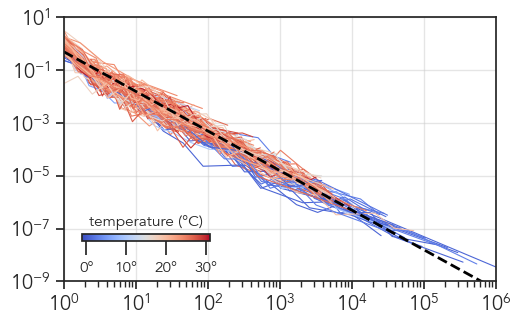

In [56]:
fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
ax.set_xscale('log')
ax.set_yscale('log')

# SRF stations
for station in SRF.station.values[::-1]:
    col = '{:03}_SRF'.format(station)
    data = Abundances[col].values
    # log histogram
    bins, counts, prob, pdf = log_hist(data[data>0], nbins=20)
    colorindex = 1+int(gdf.set_index('station', inplace=False).loc[station, 'temp_woa'])
    color = palette[colorindex]
    x = bins[:-1]
    x = x[pdf>0]
    y = pdf[pdf>0]
    sns.lineplot(x=x, y=y, ax=ax, color=color, lw=.8, ls='-', alpha=1, zorder=1)
    
print(len(SRF))
    
# DCm stations
for station in DCM.station.values[::-1]:
    col = '{:03}_DCM'.format(station)
    data = Abundances[col].values
    # log histogram
    bins, counts, prob, pdf = log_hist(data[data>0], nbins=20)
    colorindex = 1+int(gdf.set_index('station', inplace=False).loc[station, 'temp_woa'])
    color = palette[colorindex]
    x = bins[:-1]
    x = x[pdf>0]
    y = pdf[pdf>0]
    sns.lineplot(x=x, y=y, ax=ax, color=color, lw=.8, ls='-', alpha=1, zorder=1)
    
print(len(DCM))
        
cax = fig.add_axes([0.15, 0.25, 0.25, 0.025])
cax.tick_params(labelsize=10, size=10)
sm = plt.cm.ScalarMappable(cmap=palettename, norm=plt.Normalize(vmin=-1, vmax=31))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, ticks=[0., 10., 20., 30.], orientation='horizontal')#, fraction=0.026, pad=-0.2)
cbar.ax.set_xticklabels(['0°', '10°', '20°', '30°'],  font='Avenir', fontsize=11)
cbar.ax.set_title('temperature (°C)', font='Avenir', fontsize=11)

ax.grid(True, which='major', axis='both', alpha=0.5, zorder=0)
ax.set_xlim(1e0, 1e6)
ax.set_ylim(1e-9, 1e1)
#ax.set_xlabel('n [#OTU]')
#ax.set_ylabel('P(n)')

# plot a powerlaw distribution with alpha=1.5
x = np.logspace(0, 6, 100)
alpha_pl = 0.5
y = alpha_pl * x**(-1-alpha_pl)
sns.lineplot(x=x, y=y, ax=ax, color='black', lw=2., ls='--', alpha=1, zorder=1)

for fig_format in fig_formats:
    fig.savefig(fig_dir + 'fig1a_SAD_all_collapsed' + fig_format, dpi=300)

### Mock SADs by multinomial sampling from a reference SAD

In [18]:
reference_station_name = '173_SRF'
data = Abundances[reference_station_name].values
data = data[data>0]

total_abundance = np.sum(data)
print('Total abundance: {}'.format(total_abundance))
print('Number of OTUs: {}'.format(len(data)))

# generate a vector of probabilities for each OTU. The probability of each OTU is proportional to its abundance.
probabilities = data/total_abundance

sampling_efforts, richnesses_observed, multisamples, richnesses, colors, temperatures = [], [], [], [], [], []

# SRF stations
for station in SRF.station.values[::-1]:
    col = '{:03}_SRF'.format(station)
    sampling_efforts.append(np.sum(Abundances[col].values))
    richnesses_observed.append(len(Abundances[col].values[Abundances[col].values>0]))
    multisamples.append(np.random.multinomial(sampling_efforts[-1], probabilities))
    richnesses.append(len(multisamples[-1][multisamples[-1]>0]))
    colorindex = 1+int(gdf.set_index('station', inplace=False).loc[station, 'temp_woa'])
    tempereature = int(gdf.set_index('station', inplace=False).loc[station, 'temp_woa'])
    temperatures.append(tempereature)
    colors.append(palette[colorindex])
    
# DCM stations
for station in DCM.station.values[::-1]:
    col = '{:03}_DCM'.format(station)
    sampling_efforts.append(np.sum(Abundances[col].values))
    richnesses_observed.append(len(Abundances[col].values[Abundances[col].values>0]))
    multisamples.append(np.random.multinomial(sampling_efforts[-1], probabilities))
    richnesses.append(len(multisamples[-1][multisamples[-1]>0]))
    colorindex = 1+int(gdf.set_index('station', inplace=False).loc[station, 'temp_woa'])
    tempereature = int(gdf.set_index('station', inplace=False).loc[station, 'temp_woa'])
    temperatures.append(tempereature)
    colors.append(palette[colorindex])

Total abundance: 312215
Number of OTUs: 422


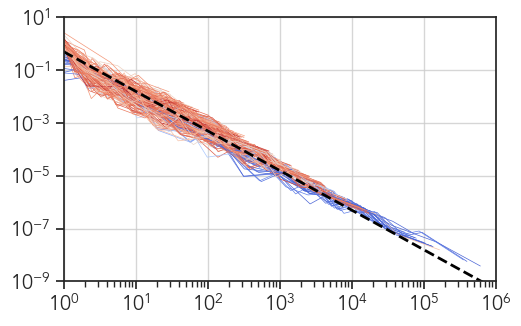

In [19]:
fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)

for i, sample in enumerate(multisamples):
    sample = sample[sample>0]
    bins, counts, prob, pdf = log_hist(sample, nbins=20)
    x = bins[:-1]
    y = pdf
    x = x[y>0]
    y = y[y>0]
    sns.lineplot(x=x, y=y, ax=ax, lw=.5, ls='-', alpha=1, zorder=1, color=colors[i])
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, which='major', axis='both', alpha=0.8, zorder=0)
ax.set_xlim(1e0, 1e6)
ax.set_ylim(1e-9, 1e1)
# sohw legend on the right
#ax.set_xlabel('n [#OTU]')
#ax.set_ylabel('P(n)')
# don't show legend
#ax.legend().set_visible(False)



# plot a powerlaw distribution with alpha=1.5
x = np.logspace(0, 6, 100)
alpha_pl = 0.5
y = alpha_pl * x**(-1-alpha_pl)
sns.lineplot(x=x, y=y, ax=ax, color='black', lw=2., ls='--', alpha=1, zorder=1)

for fig_format in fig_formats:
    fig.savefig(fig_dir + 'fig1b_SAD_multisample' + fig_format, dpi=300)

### Richness comparison

Pearson correlation coefficient: 0.83
r^2: 0.70
p-value: 1.7368158500943906e-46


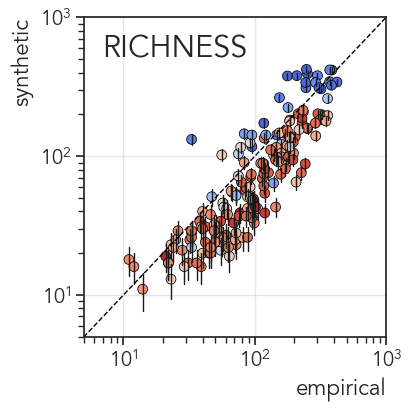

In [20]:
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)

x = np.array (richnesses_observed)
y = np.array(richnesses)
max_y = np.max(y)
y = y[x<=max_y]
cs = np.array(colors)[x<=max_y]
x = x[x<=max_y]

# calculate correlation coefficient and p-value between observed and synthetic richnesses
r, p = pearsonr(x, y)
print('Pearson correlation coefficient: {0:1.2f}'.format(r))
print('r^2: {0:1.2f}'.format(r**2))
print('p-value: {}'.format(p))


sns.scatterplot(x=x, y=y, ax=ax, s=50, color=cs, alpha=1, zorder=1, lw=0.1, edgecolor='black')
# add error bars
for i in range(len(x)):
    ax.plot([x[i], x[i]], [y[i]-np.sqrt(y[i]), y[i]+np.sqrt(y[i])], color='k', lw=1, alpha=1, zorder=1)
ax.set_xlabel('empirical', loc='right', font='Avenir', fontsize=16)
ax.set_ylabel('synthetic', loc='top', font='Avenir', fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, which='major', axis='both', alpha=0.5, zorder=0)
ax.set_xlim(5*1e0, 1e3)
ax.set_ylim(5*1e0, 1e3)

# write text "RICHNESS"
ax.text(0.3, 0.85, 'RICHNESS', transform=ax.transAxes, font='Avenir', fontsize=22, fontweight='bold', ha='center', va='bottom')

'''
cax = fig.add_axes([0.275, 0.85, 0.25, 0.02])
sm = plt.cm.ScalarMappable(cmap=palettename, norm=plt.Normalize(vmin=-1, vmax=31))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, ticks=[0., 10., 20., 30.], orientation='horizontal')#, fraction=0.026, pad=-0.2)
cbar.ax.set_xticklabels(['0°', '10°', '20°', '30°'],  font='Avenir', fontsize=10)
cbar.ax.set_title('temperature (°C)', font='Avenir')
# change size of the colorbar title
cbar.ax.title.set_fontsize(12)
'''

# draw a 1:1 line
ax.plot([1, 1e4], [1, 1e4], color='black', lw=1, ls='--', alpha=1, zorder=1)

for fig_format in fig_formats:
    fig.savefig(fig_dir + 'fig1c_richness' + fig_format, dpi=300)

## Richness scaling

Richness of 173_SRF: 422.0
Total abundance of 173_SRF: 312215.0
R^2: 0.8071518797937911 p-value: 4.579996318135748e-45 slope: 0.33496053371120876 intercept: 0.7303358668055395


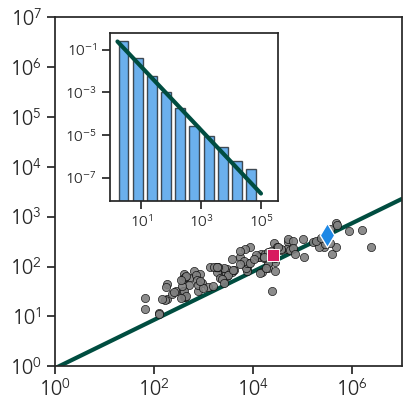

In [21]:
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_yticks(np.logspace(0, 8, 9))
# move the ticks to the right
#ax.yaxis.tick_right()
#ax.yaxis.set_label_position("right")
ax.set_xlim(1*1e0, 1e7)
ax.set_ylim(1*1e0, 1e7)

palettename = 'coolwarm'
palette = sns.color_palette(palettename, 32)
# scatter plot of all but 173_SRF
colors = [palette[1+int(SRF.set_index('station', inplace=False).loc[station, 'temp_woa'])] for station in Stations if ((station in SRF['station'].values) and (station!=173) and (station!=43))]
sns.scatterplot(y='Richness_SRF', x='TotAbundance_SRF', color='grey', data=SRF.loc[((SRF['station']!=173) & (SRF['station']!=43))], s=35, zorder=50, ax=ax, lw=1, edgecolor='black',alpha=.9)
# scatter plot of 173_SRF
sns.scatterplot(y='Richness_SRF', x='TotAbundance_SRF', color='#1E88E5', data=SRF.loc[SRF['station']==173], s=150, zorder=100, ax=ax, lw=40, edgecolor='w', marker='d')
# scatter plot of 43_SRF
sns.scatterplot(y='Richness_SRF', x='TotAbundance_SRF', color='#D81B60', data=SRF.loc[SRF['station']==43], s=75, zorder=100, ax=ax, lw=40, edgecolor='w', marker='s')

print('Richness of 173_SRF: {}'.format(SRF.loc[SRF['station']==173,'Richness_SRF'].values[0]))
print('Total abundance of 173_SRF: {}'.format(SRF.loc[SRF['station']==173,'TotAbundance_SRF'].values[0]))
Sref = SRF.loc[SRF['station']==173,'Richness_SRF'].values[0]
Nref = SRF.loc[SRF['station']==173,'TotAbundance_SRF'].values[0]
lambdaref = SRF.loc[SRF['station']==173,'lambda_SRF'].values[0]
Np = np.logspace(0., 7, 100)
Sp = Sref * (Np/Nref)**(lambdaref-1)
sns.lineplot(x=Np, y=Sp, color='#004D40', lw=3, ls='-', alpha=1, zorder=1, ax=ax) 

# print R^2 for log-log regression of Richness vs Total Abundance
X = np.log10(SRF['TotAbundance_SRF'].values)
Y = np.log10(SRF['Richness_SRF'].values)
slope, intercept, r_value, p_value, std_err = linregress(X, Y)
print('R^2: {}'.format(r_value**2), 'p-value: {}'.format(p_value), 'slope: {}'.format(slope), 'intercept: {}'.format(intercept))
               
x = np.logspace(0.5, 7, 8)
y = x**(0.5)
#sns.scatterplot(x=x, y=y, ls='-', alpha=1, zorder=1, ax=ax,  color='k', s=50)
#sns.lineplot(x=x, y=x, color='k', lw=2, ls='--')
#sns.lineplot(x=x, y=np.ones(len(x)), color='grey', lw=3, ls='--')
#cax = fig.add_axes([0.6, 0.2, 0.25, 0.025])
#cax.tick_params(labelsize=10, size=10)
#sm = plt.cm.ScalarMappable(cmap=palettename, norm=plt.Normalize(vmin=-1, vmax=31))
#sm._A = []
#cbar = fig.colorbar(sm, cax=cax, ticks=[0., 10., 20., 30.], orientation='horizontal')#, fraction=0.026, pad=-0.2)
#cbar.ax.set_xticklabels(['0°', '10°', '20°', '30°'],  font='Avenir', fontsize=11)
#cbar.ax.set_title('temperature (°C)', font='Avenir', fontsize=11)

ax.set_xlabel('')
ax.set_ylabel('')
#ax.set_xlabel('Total Abundance')
#ax.set_ylabel('Richness')

# SAD of 173_SRF
cax1 = fig.add_axes([0.26, 0.51, 0.42, 0.42])
data = Abundances[reference_station_name].values
bins, counts, prob, pdf = log_hist(data[data>0], nbins=12)
widths = np.diff(bins)
x = np.sqrt(bins[:-1] * bins[1:])
cax1.bar(x, pdf, width=widths, align='edge', color='#1E88E5', linewidth=1, edgecolor='black', alpha=0.66)
cax1.set_xscale('log')
cax1.set_yscale('log')
cax1.set_xticks([1e1, 1e3, 1e5])
cax1.set_xticklabels(cax1.get_xticklabels(), fontsize=11)
cax1.set_yticks([1e-7, 1e-5, 1e-3, 1e-1])
cax1.set_yticklabels(cax1.get_yticklabels(), fontsize=11)

# powerlaw distribution with lambda of 173_SRF
x = np.logspace(0.2, 5, 100)
alpha_pl = SRF.loc[SRF['station']==173,'lambda_SRF'].values[0] - 1
y = alpha_pl * x**(-1-alpha_pl)
sns.lineplot(x=x, y=y, ax=cax1, color='#004D40', lw=3., ls='-', alpha=1, zorder=1)


for fig_format in fig_formats:
    fig.savefig(fig_dir + 'fig2b_richness_abundance' + fig_format, dpi=300)

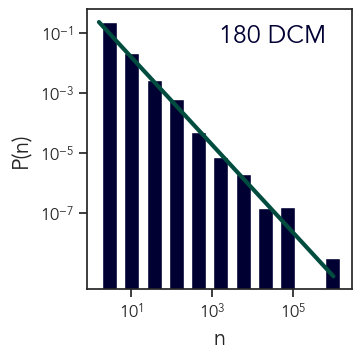

In [22]:
# SAD of 180 DCM

data = Abundances['180_DCM'].values
bins, counts, prob, pdf = log_hist(data[data>0], nbins=12)
widths = np.diff(bins)
x = np.sqrt(bins[:-1] * bins[1:])

fig, ax = plt.subplots(figsize=(3.5,3.5), constrained_layout=True)

ax.bar(x, pdf, width=widths, align='edge', color=colorDCM, linewidth=1, edgecolor='w', alpha=1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([1e1, 1e3, 1e5])
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticks([1e-7, 1e-5, 1e-3, 1e-1])
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.set_xlabel('n')
ax.set_ylabel('P(n)')

# powerlaw distribution with lambda of 180_DCM
x = np.logspace(0.2, 6, 100)
alpha_pl = DCM.loc[SRF['station']==180,'lambda_DCM'].values[0] - 1
y = alpha_pl * x**(-1-alpha_pl)
sns.lineplot(x=x, y=y, ax=ax, color='#004D40', lw=3., ls='-', alpha=1, zorder=1)

ax.text(0.5, 0.95, '180 DCM', transform=ax.transAxes, font='Avenir', fontsize=18, fontweight='bold', ha='left', va='top', color=colorDCM)

for fig_format in fig_formats:
    fig.savefig(supfig_dir + 'figS5_SAD_180_DCM' + fig_format, dpi=300)

## Power law fits

### Histograms of the power law exponents

Average lambda SRF: 1.44 
Average lambda DCM: 1.38


Text(0.5, 0.98, 'PL')

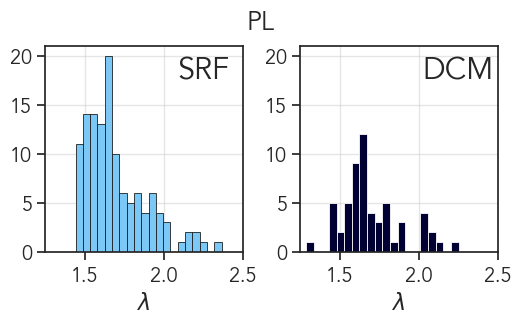

In [23]:
fig, axes = plt.subplots(1,2, figsize=figsize, constrained_layout=True)

print('Average lambda SRF: {0:1.2f} \nAverage lambda DCM: {1:1.2f}'.format(SRF['lambda_SRF'].mean(), DCM['lambda_DCM'].mean()))

sns.histplot(x='lambda_PL', data=SRF, ax=axes[0], bins=20, stat='count', edgecolor='k', lw=1, color=colorSRF, alpha=1, zorder=1)
sns.histplot(x='lambda_PL', data=DCM, ax=axes[1], bins=20, stat='count', edgecolor='w', lw=1, color=colorDCM, alpha=1, zorder=1)

axes[0].text(0.8, 0.8, 'SRF', transform=axes[0].transAxes, font='Avenir', fontsize=22, fontweight='bold', ha='center', va='bottom')
axes[1].text(0.8, 0.8, 'DCM', transform=axes[1].transAxes, font='Avenir', fontsize=22, fontweight='bold', ha='center', va='bottom')

for ax in axes:
    ax.set_xlabel(r'$\lambda$', font='Avenir', fontsize=16)
    ax.set_ylabel('', font='Avenir', fontsize=16)
    ax.set_xlim(1.25, 2.5)
    ax.set_ylim(0, 21)
    ax.grid(True, which='major', axis='both', alpha=0.5, zorder=0)
    
fig.suptitle('PL')

Average lambda SRF: 1.44 
Average lambda DCM: 1.38


Text(0.5, 0.98, 'ES')

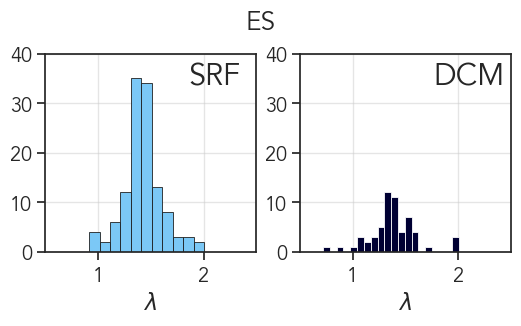

In [24]:
fig, axes = plt.subplots(1,2, figsize=figsize, constrained_layout=True)

print('Average lambda SRF: {0:1.2f} \nAverage lambda DCM: {1:1.2f}'.format(SRF['lambda_SRF'].mean(), DCM['lambda_DCM'].mean()))

sns.histplot(x='lambda_SRF', data=SRF, ax=axes[0], bins=20, stat='count', edgecolor='k', lw=1, color=colorSRF, alpha=1, zorder=1, label='SRF')
sns.histplot(x='lambda_DCM', data=DCM, ax=axes[1], bins=20, stat='count', edgecolor='w', lw=1, color=colorDCM, alpha=1, zorder=1)

axes[0].text(0.8, 0.8, 'SRF', transform=axes[0].transAxes, font='Avenir', fontsize=22, fontweight='bold', ha='center', va='bottom')
axes[1].text(0.8, 0.8, 'DCM', transform=axes[1].transAxes, font='Avenir', fontsize=22, fontweight='bold', ha='center', va='bottom')

for ax in axes:
    ax.set_xlabel(r'$\lambda$', font='Avenir', fontsize=16)
    ax.set_ylabel('', font='Avenir', fontsize=16)
    ax.set_xlim(.5, 2.5)
    ax.set_ylim(0, 40)
    ax.grid(True, which='major', axis='both', alpha=0.5, zorder=0)
    
fig.suptitle('ES')

Total abundance: 312215
lambda PL: 1.654193201801047
lambda fit: 1.485529379081201


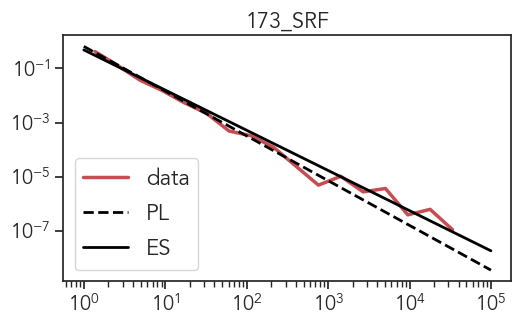

In [25]:
fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
ax.set_xscale('log')
ax.set_yscale('log')

station = '173_SRF'
ax.set_title(station)

data = Abundances[station].values
print('Total abundance: {}'.format(np.sum(data)))
print('lambda PL: {}'.format(lambda_dict['173_SRF']))
print('lambda fit: {}'.format(fits.loc['173_SRF','lambda']))

bins, counts, prob, pdf = log_hist(data[data>0], nbins=20)
x = np.sqrt(bins[:-1]*bins[1:])
y = pdf
x = x[y>0]
y = y[y>0]
sns.lineplot(x=x, y=y, ax=ax, lw=2.5, ls='-', alpha=1, zorder=1, color='r', label='data')

# power law fit plot
x = np.logspace(0, 5, 100)
alpha_pl = lambda_dict[station]-1
y = alpha_pl * x**(-alpha_pl-1)
sns.lineplot(x=x, y=y, ax=ax, color='black', lw=2., ls='--', alpha=1, zorder=1, label='PL')

# Bruno fit
x = np.logspace(0, 5, 100)
lambda_SRF = fits.loc[station,'lambda']-1
y = lambda_SRF * x**(-lambda_SRF-1)
sns.lineplot(x=x, y=y, ax=ax, color='black', lw=2., ls='-', alpha=1, zorder=1, label='ES')

ax.legend(fontsize=16, loc='lower left')




## Comparison of the results of the different methods

read 0.654193201801047 0.485529379081201


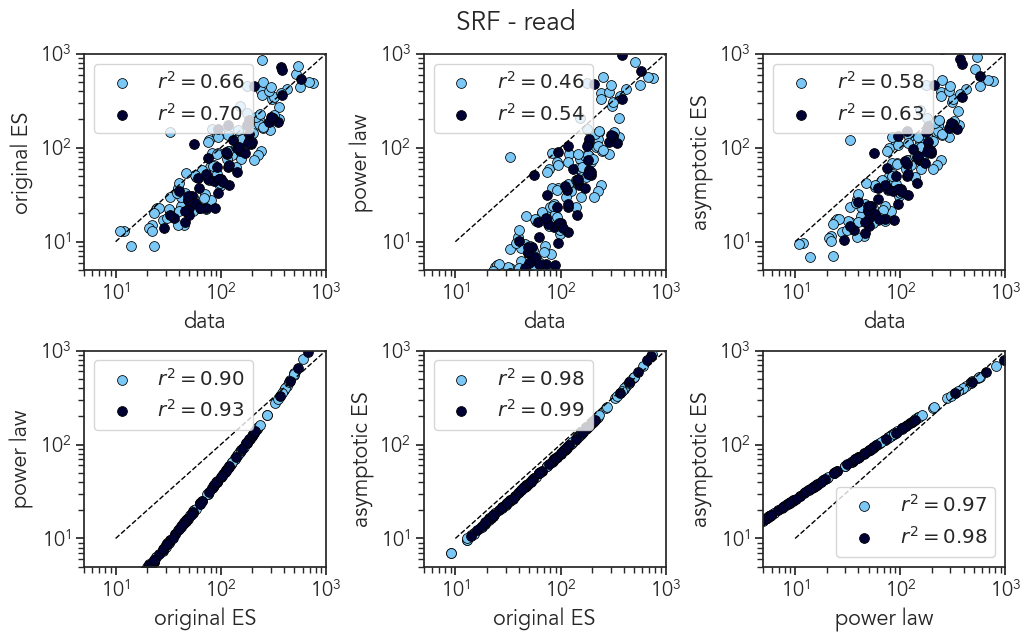

In [26]:
print(which, rho_PL, rho_asympt)

cols = ['Richness_SRF', 'Spred_original', 'Spred_PL', 'Spred_asympt']

def return_name(col):
    if 'original' in col:
        return 'original ES'
    elif 'PL' in col:
        return 'power law'
    elif 'asympt' in col:
        return 'asymptotic ES'
    elif 'Richness' in col:
        return 'data'
    else:
        return None

fig, axes = plt.subplots(2, 3, figsize=(figsize[0]*2, figsize[1]*2), constrained_layout=True)
fig.suptitle('SRF - {}'.format(which))

for i, (col1, col2) in enumerate(itertools.combinations(cols, 2)):
    ax = axes.flatten()[i]
    ax.set_xscale('log') 
    ax.set_yscale('log')
    ax.set_xlim(5*1e0, 1e3)
    ax.set_ylim(5*1e0, 1e3)
    ax.set_xlabel(return_name(col1))
    ax.set_ylabel(return_name(col2))
    r, p = pearsonr(SRF[col1], SRF[col2])
    #print('{} - {}: r = {}, p = {}'.format(col1, col2, r, p))
    sns.scatterplot(x=SRF[col1], y=SRF[col2], ax=ax, label=r'$r^2={:.2f}$'.format(r**2), s=50, color=colorSRF, alpha=1, zorder=1, lw=0.1, edgecolor='black')
    if col1 == 'Richness_SRF':
        col1 = 'Richness_DCM'
    if col2 == 'Richness_SRF':
        col2 = 'Richness_DCM'
    r, p = pearsonr(DCM[col1], DCM[col2])
    sns.scatterplot(x=DCM[col1], y=DCM[col2], ax=ax, s=50, label=r'$r^2={:.2f}$'.format(r**2), color=colorDCM, alpha=1, zorder=1, lw=0.1, edgecolor='black')
    
    # draw a 1:1 line
    ax.plot([1e1, 1e3], [1e1, 1e3], color='black', lw=1, ls='--', alpha=1, zorder=1)

plt.show()

for fig_format in fig_formats:
    fig.savefig(supfig_dir + 'Spred_comparison_{}'.format(which) + fig_format, dpi=300)

In [27]:
print(ref_station)

180_DCM


SRF: r = 0.7606014757960037, p = 1.884950303333138e-24
DCM: r = 0.7947464774426721, p = 9.498102744241195e-14
SRF: r = 0.7503303924749005, p = 1.7024863765676835e-23
DCM: r = 0.7862074681002171, p = 2.628700424359009e-13
SRF: r = 0.7797774433039345, p = 2.2682747455698076e-26
DCM: r = 0.8114181812034109, p = 1.1255816704948815e-14


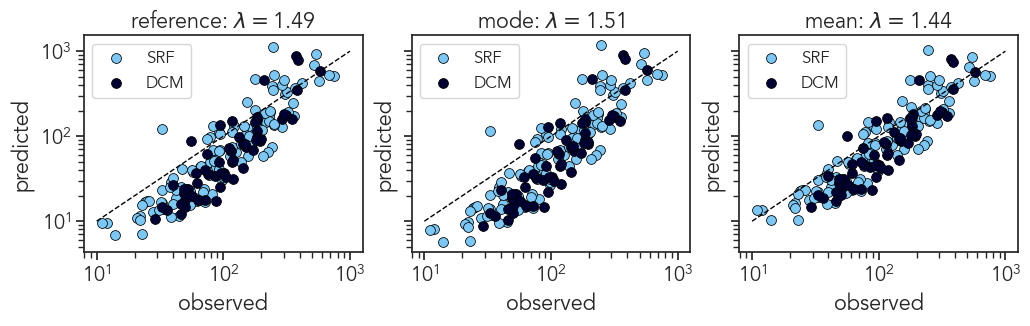

In [28]:
ref_station_SRF = '173_SRF'
ref_station_SRF_number = int(ref_station_SRF.split('_')[0])
N_ref, S_ref = SRF.loc[SRF['station']==ref_station_SRF_number,['TotAbundance_SRF', 'Richness_SRF']].values[0]

rho_asympt_ref = SRF.loc[SRF['station']==ref_station_SRF_number,'lambda_SRF'].values[0] - 1
ypred_ref_SRF = S_ref * (SRF['TotAbundance_SRF']/N_ref)**(rho_asympt_ref)
ypred_ref_DCM = S_ref * (DCM['TotAbundance_DCM']/N_ref)**(rho_asympt_ref)
rho_asympt_mode = mode_with_binning(SRF['lambda_SRF'], bins=5) - 1 
ypred_mode_SRF = S_ref * (SRF['TotAbundance_SRF']/N_ref)**(rho_asympt_mode)
ypred_mode_DCM = S_ref * (DCM['TotAbundance_DCM']/N_ref)**(rho_asympt_mode)
rho_asympt_mean = np.round(SRF['lambda_SRF'].mean() - 1, 2)
ypred_mean_SRF = S_ref * (SRF['TotAbundance_SRF']/N_ref)**(rho_asympt_mean)
ypred_mean_DCM = S_ref * (DCM['TotAbundance_DCM']/N_ref)**(rho_asympt_mean)

fig, axes = plt.subplots(1, 3, figsize=(figsize[0]*2, figsize[1]), constrained_layout=True, sharey=True)
#fig.suptitle('Richness downscaling')

ax = axes[0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
ax.set_title(r'reference: $\lambda=${0:1.2f}'.format(rho_asympt_ref+1))
# SRF
x, y = SRF['Richness_SRF'], ypred_ref_SRF
r, p = pearsonr(x, y)
print('SRF: r = {}, p = {}'.format(r, p))
label = r'$r^2={:.2f}$'.format(r**2)
sns.scatterplot(x=x, y=y, ax=ax, label='SRF', s=50, color=colorSRF, alpha=1, zorder=1, lw=0.1, edgecolor='black')
# DCM
x, y = DCM['Richness_DCM'], ypred_ref_DCM
r, p = pearsonr(x, y)
print('DCM: r = {}, p = {}'.format(r, p))
sns.scatterplot(x=x, y=y, ax=ax, s=50, label='DCM', color=colorDCM, alpha=1, zorder=1, lw=0.1, edgecolor='black')

# draw a 1:1 line
ax.plot([1e1, 1e3], [1e1, 1e3], color='black', lw=1, ls='--', alpha=1, zorder=1)
ax.legend(fontsize=12, loc='upper left')

ax = axes[1]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
ax.set_title(r'mode: $\lambda=${0:1.2f}'.format(rho_asympt_mode+1))
# SRF
x, y = SRF['Richness_SRF'], ypred_mode_SRF
r, p = pearsonr(x, y)
print('SRF: r = {}, p = {}'.format(r, p))
label = r'$r^2={:.2f}$'.format(r**2)
sns.scatterplot(x=x, y=y, ax=ax, label='SRF', s=50, color=colorSRF, alpha=1, zorder=1, lw=0.1, edgecolor='black')
# DCM
x, y = DCM['Richness_DCM'], ypred_mode_DCM
r, p = pearsonr(x, y)
print('DCM: r = {}, p = {}'.format(r, p))
sns.scatterplot(x=x, y=y, ax=ax, s=50, label='DCM', color=colorDCM, alpha=1, zorder=1, lw=0.1, edgecolor='black')

# draw a 1:1 line
ax.plot([1e1, 1e3], [1e1, 1e3], color='black', lw=1, ls='--', alpha=1, zorder=1)
ax.legend(fontsize=12, loc='upper left')

ax = axes[2]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
ax.set_title(r'mean: $\lambda=${0:1.2f}'.format(rho_asympt_mean+1))
# SRF
x, y = SRF['Richness_SRF'], ypred_mean_SRF
r, p = pearsonr(x, y)
print('SRF: r = {}, p = {}'.format(r, p))
label = r'$r^2={:.2f}$'.format(r**2)
sns.scatterplot(x=x, y=y, ax=ax, label='SRF', s=50, color=colorSRF, alpha=1, zorder=1, lw=0.1, edgecolor='black')
# DCM
x, y = DCM['Richness_DCM'], ypred_mean_DCM
r, p = pearsonr(x, y)
print('DCM: r = {}, p = {}'.format(r, p))
sns.scatterplot(x=x, y=y, ax=ax, s=50, label='DCM', color=colorDCM, alpha=1, zorder=1, lw=0.1, edgecolor='black')

# draw a 1:1 line
ax.plot([1e1, 1e3], [1e1, 1e3], color='black', lw=1, ls='--', alpha=1, zorder=1)
ax.legend(fontsize=12, loc='upper left')

for fig_format in fig_formats:
    fig.savefig(supfig_dir + 'figS2_downscaling_comparison' + fig_format, dpi=300)


SRF: r = 0.7709726666851529, p = 1.820680578607356e-25
DCM: r = 0.8036377671819739, p = 3.123446331439206e-14
SRF: r = 0.7503303924749005, p = 1.7024863765676835e-23
DCM: r = 0.7862074681002171, p = 2.628700424359009e-13
SRF: r = 0.7797774433039345, p = 2.2682747455698076e-26
DCM: r = 0.8114181812034109, p = 1.1255816704948815e-14


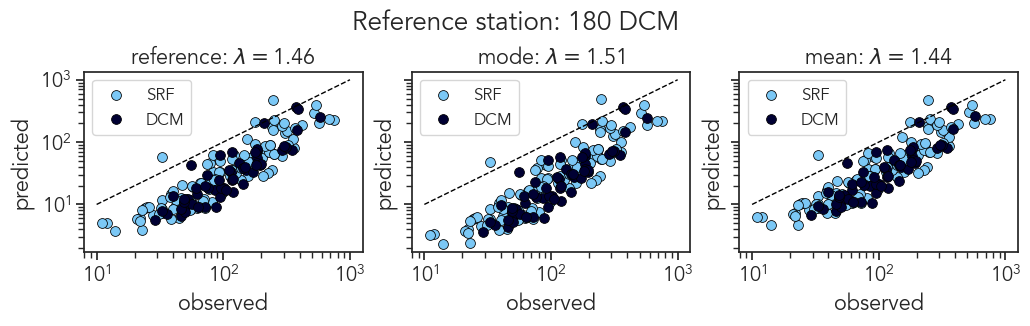

In [29]:
# Downscaling from 180 DCM
ref_station_DCM = '180_DCM'
ref_station_DCM_number = int(ref_station_DCM.split('_')[0])
N_ref, S_ref = DCM.loc[DCM['station']==ref_station_DCM_number,['TotAbundance_DCM', 'Richness_DCM']].values[0]

rho_asympt_ref = DCM.loc[DCM['station']==ref_station_DCM_number,'lambda_DCM'].values[0] - 1
ypred_ref_SRF = S_ref * (SRF['TotAbundance_SRF']/N_ref)**(rho_asympt_ref)
ypred_ref_DCM = S_ref * (DCM['TotAbundance_DCM']/N_ref)**(rho_asympt_ref)
rho_asympt_mode = mode_with_binning(SRF['lambda_SRF'], bins=5) - 1 
ypred_mode_SRF = S_ref * (SRF['TotAbundance_SRF']/N_ref)**(rho_asympt_mode)
ypred_mode_DCM = S_ref * (DCM['TotAbundance_DCM']/N_ref)**(rho_asympt_mode)
rho_asympt_mean = np.round(SRF['lambda_SRF'].mean() - 1, 2)
ypred_mean_SRF = S_ref * (SRF['TotAbundance_SRF']/N_ref)**(rho_asympt_mean)
ypred_mean_DCM = S_ref * (DCM['TotAbundance_DCM']/N_ref)**(rho_asympt_mean)

fig, axes = plt.subplots(1, 3, figsize=(figsize[0]*2, figsize[1]), constrained_layout=True, sharey=True)
#fig.suptitle('Richness downscaling')

ax = axes[0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
ax.set_title(r'reference: $\lambda=${0:1.2f}'.format(rho_asympt_ref+1))
# SRF
x, y = SRF['Richness_SRF'], ypred_ref_SRF
r, p = pearsonr(x, y)
print('SRF: r = {}, p = {}'.format(r, p))
label = r'$r^2={:.2f}$'.format(r**2)
sns.scatterplot(x=x, y=y, ax=ax, label='SRF', s=50, color=colorSRF, alpha=1, zorder=1, lw=0.1, edgecolor='black')
# DCM
x, y = DCM['Richness_DCM'], ypred_ref_DCM
r, p = pearsonr(x, y)
print('DCM: r = {}, p = {}'.format(r, p))
sns.scatterplot(x=x, y=y, ax=ax, s=50, label='DCM', color=colorDCM, alpha=1, zorder=1, lw=0.1, edgecolor='black')

# draw a 1:1 line
ax.plot([1e1, 1e3], [1e1, 1e3], color='black', lw=1, ls='--', alpha=1, zorder=1)
ax.legend(fontsize=12, loc='upper left')

ax = axes[1]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
ax.set_title(r'mode: $\lambda=${0:1.2f}'.format(rho_asympt_mode+1))
# SRF
x, y = SRF['Richness_SRF'], ypred_mode_SRF
r, p = pearsonr(x, y)
print('SRF: r = {}, p = {}'.format(r, p))
label = r'$r^2={:.2f}$'.format(r**2)
sns.scatterplot(x=x, y=y, ax=ax, label='SRF', s=50, color=colorSRF, alpha=1, zorder=1, lw=0.1, edgecolor='black')
# DCM
x, y = DCM['Richness_DCM'], ypred_mode_DCM
r, p = pearsonr(x, y)
print('DCM: r = {}, p = {}'.format(r, p))
sns.scatterplot(x=x, y=y, ax=ax, s=50, label='DCM', color=colorDCM, alpha=1, zorder=1, lw=0.1, edgecolor='black')

# draw a 1:1 line
ax.plot([1e1, 1e3], [1e1, 1e3], color='black', lw=1, ls='--', alpha=1, zorder=1)
ax.legend(fontsize=12, loc='upper left')

ax = axes[2]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
ax.set_title(r'mean: $\lambda=${0:1.2f}'.format(rho_asympt_mean+1))
# SRF
x, y = SRF['Richness_SRF'], ypred_mean_SRF
r, p = pearsonr(x, y)
print('SRF: r = {}, p = {}'.format(r, p))
label = r'$r^2={:.2f}$'.format(r**2)
sns.scatterplot(x=x, y=y, ax=ax, label='SRF', s=50, color=colorSRF, alpha=1, zorder=1, lw=0.1, edgecolor='black')
# DCM
x, y = DCM['Richness_DCM'], ypred_mean_DCM
r, p = pearsonr(x, y)
print('DCM: r = {}, p = {}'.format(r, p))
sns.scatterplot(x=x, y=y, ax=ax, s=50, label='DCM', color=colorDCM, alpha=1, zorder=1, lw=0.1, edgecolor='black')

# draw a 1:1 line
ax.plot([1e1, 1e3], [1e1, 1e3], color='black', lw=1, ls='--', alpha=1, zorder=1)
ax.legend(fontsize=12, loc='upper left')

fig.suptitle('Reference station: {} DCM'.format(ref_station_DCM_number))

for fig_format in fig_formats:
    fig.savefig(supfig_dir + 'figS4_downscaling_reference180DCM' + fig_format, dpi=300)


## Richness scatter plots

### From power law fits

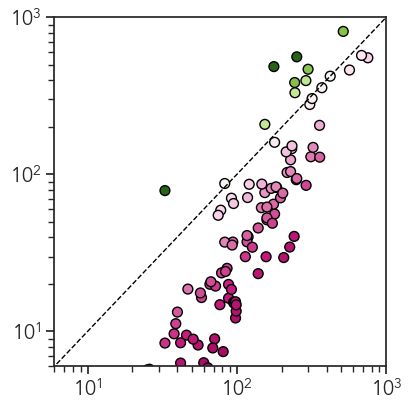

In [30]:
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)

# Create a colormap
cmap = plt.get_cmap("PiYG")
# Create a two-slope normalization centered around 0
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

# Use ax.scatter instead of seaborn
sc = ax.scatter(SRF['Richness_SRF'], SRF['Spred_PL'], c=SRF['DeltaS_PL'], cmap=cmap, norm=norm, s=50, edgecolor='black', linewidth=1)

ax.set(xscale="log", yscale="log", xlim=(6,1000), ylim=(6,1000), 
       xlabel='', 
       ylabel=''
      )

x = np.linspace(6,1200)
#ax.plot(x,x+0.,ls ='--', color='grey', lw=2.5, zorder=-100)
ax.plot([1, 1e4], [1, 1e4], color='black', lw=1, ls='--', alpha=1, zorder=1)

plt.show()
#fig.savefig(fig_dir  + 'fig3_S.svg', facecolor='none', edgecolor='none')


### From asymptotic behaviour of original fits

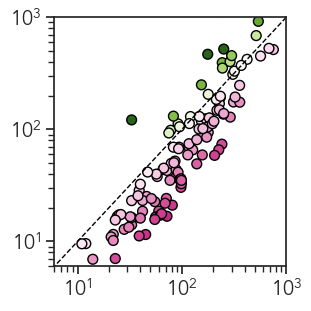

In [31]:
fig, ax = plt.subplots(figsize=(3,3), constrained_layout=True)

# Create a colormap
cmap = plt.get_cmap("PiYG")
# Create a two-slope normalization centered around 0
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

# Use ax.scatter instead of seaborn
sc = ax.scatter(SRF['Richness_SRF'], SRF['Spred_asympt'], c=SRF['DeltaS_asympt'], cmap=cmap, norm=norm, s=50, edgecolor='black', linewidth=1)

ax.set(xscale="log", yscale="log", xlim=(6,1000), ylim=(6,1000), 
       xlabel='', 
       ylabel=''
      )

x = np.linspace(6,1200)
#ax.plot(x,x+0.,ls ='--', color='grey', lw=2.5, zorder=-100)
ax.plot([1, 1e4], [1, 1e4], color='black', lw=1, ls='--', alpha=1, zorder=1)

plt.show()
for fig_format in fig_formats:
    fig.savefig(fig_dir + 'fig2_S_scatter_asympt' + fig_format, dpi=300)


### Original downscaling

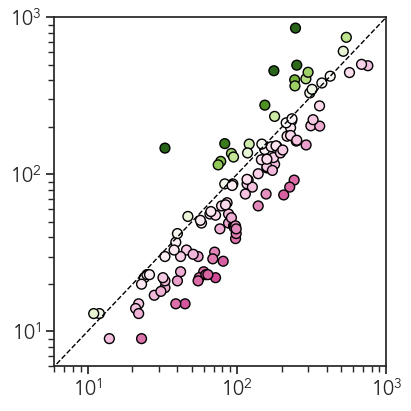

In [32]:
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)

# Create a colormap
cmap = plt.get_cmap("PiYG")
# Create a two-slope normalization centered around 0
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

# Use ax.scatter instead of seaborn
sc = ax.scatter(SRF['Richness_SRF'], SRF['Spred_original'], c=SRF['DeltaS_original'], cmap=cmap, norm=norm, s=50, edgecolor='black', linewidth=1)

ax.set(xscale="log", yscale="log", xlim=(6,1000), ylim=(6,1000), 
       xlabel='', 
       ylabel=''
      )

x = np.linspace(6,1200)
#ax.plot(x,x+0.,ls ='--', color='grey', lw=2.5, zorder=-100)
ax.plot([1, 1e4], [1, 1e4], color='black', lw=1, ls='--', alpha=1, zorder=1)

plt.show()
for fig_format in fig_formats:
    fig.savefig(fig_dir + 'fig2_S_scatter_original' + fig_format, dpi=300)


## DeltaS

### Different reference stations

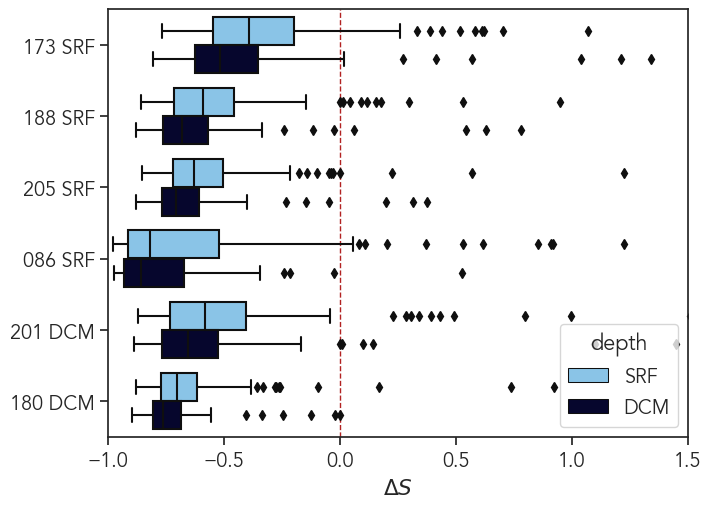

In [33]:
columns_to_plot = ['depth', '173 SRF', '188 SRF', '205 SRF', '086 SRF', '201 DCM', '180 DCM']

# Reshaping the DataFrame
df_melted = df_DS.melt(id_vars=['depth'], value_vars=columns_to_plot[1:], var_name='feature', value_name='value')

# Creating the boxplot
fig, ax = plt.subplots(figsize=(7,5), constrained_layout=True)
sns.boxplot(y='feature', x='value', hue='depth', data=df_melted, palette=[colorSRF, colorDCM], ax=ax)
ax.set_xlim(-1, 1.5)
ax.set_xlabel(r'$\Delta S$')
ax.set_ylabel('')
ax.axvline(x=0, color='firebrick', ls='--', lw=1, zorder=-100)

for fig_format in fig_formats:
    fig.savefig(supfig_dir + 'figS3_boxplotDS' + fig_format, dpi=300)

### Power law fits

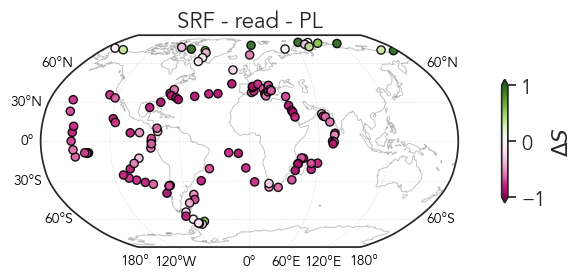

In [34]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=(7,4))
ax.set_global()
#ax.stock_img()
ax.coastlines(alpha=0.25,lw=0.65)

# change font size of the grid labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.2, linestyle='--', zorder=0,  xlabel_style={'size': 10, 'color': 'black'}, ylabel_style={'size': 10, 'color': 'black'})
# remove grid labels on top and right
gl.top_labels = False
gl.right_labels = False

column = "DeltaS_PL"
cmap = "PiYG"
#cmap = cmocean.cm.balance
cbar = SRF.plot(column=column, cmap=cmap, transform = ccrs.Geodetic(), ax=ax, zorder=10, vmin=-1., vmax=1.,
                #norm=clrs.Norm(vmin=gdf[column].min(), vmax=gdf[column].max()),
         legend=True, alpha=0.9, lw=1, edgecolors='black', s=35,
                 legend_kwds={'shrink': 0.4, 'pad':0.08, #'ticks':ticks,# 'set_yticklabels':ticks_labels,
                      'orientation': 'vertical', 
                      'extend':'both', "fmt": "{:1.0e}",
                      'label': r'$\Delta S$'
                     })

ax.set_title('SRF - {} - PL'.format(which), font='Avenir', fontsize=16)
for fig_format in fig_formats:
        fig.savefig(supfig_dir + 'DeltaS_{}_SRF_PL'.format(which) + fig_format, dpi=300)

### Asymptotic behavior of fits

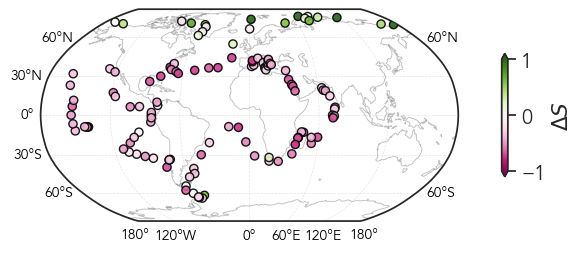

In [35]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=(7,4))
ax.set_global()
#ax.stock_img()
ax.coastlines(alpha=0.25,lw=0.65)

# change font size of the grid labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.2, linestyle='--', zorder=0,  xlabel_style={'size': 10, 'color': 'black'}, ylabel_style={'size': 10, 'color': 'black'})
# remove grid labels on top and right
gl.top_labels = False
gl.right_labels = False

column = "DeltaS_asympt"
cmap = "PiYG"
#cmap = cmocean.cm.balance
cbar = SRF.plot(column=column, cmap=cmap, transform = ccrs.Geodetic(), ax=ax, zorder=10, vmin=-1., vmax=1.,
                #norm=clrs.Norm(vmin=gdf[column].min(), vmax=gdf[column].max()),
         legend=True, alpha=0.9, lw=1, edgecolors='black', s=35,
                 legend_kwds={'shrink': 0.4, 'pad':0.08, #'ticks':ticks,# 'set_yticklabels':ticks_labels,
                      'orientation': 'vertical', 
                      'extend':'both', "fmt": "{:1.0e}",
                      'label': r'$\Delta S$'
                     })


#ax.set_title('SRF - {} - asymptotic ES'.format(which), font='Avenir', fontsize=16)
for fig_format in fig_formats:
        fig.savefig(fig_dir + 'fig2c_DeltaS_{}_SRF_asympt'.format(which) + fig_format, dpi=300)

### Original downscaling

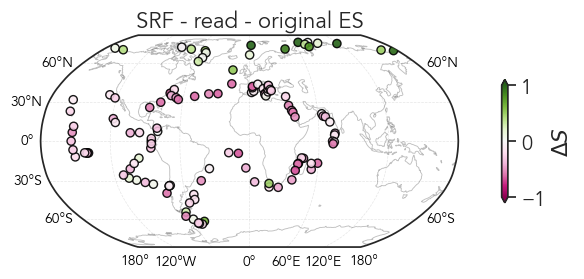

In [36]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=(7,4))
ax.set_global()
#ax.stock_img()
ax.coastlines(alpha=0.25,lw=0.65)

# change font size of the grid labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.2, linestyle='--', zorder=0,  xlabel_style={'size': 10, 'color': 'black'}, ylabel_style={'size': 10, 'color': 'black'})
# remove grid labels on top and right
gl.top_labels = False
gl.right_labels = False

column = "DeltaS_original"
cmap = "PiYG"
#cmap = cmocean.cm.balance
cbar = SRF.plot(column=column, cmap=cmap, transform = ccrs.Geodetic(), ax=ax, zorder=10, vmin=-1., vmax=1.,
                #norm=clrs.Norm(vmin=gdf[column].min(), vmax=gdf[column].max()),
         legend=True, alpha=0.9, lw=1, edgecolors='black', s=35,
                 legend_kwds={'shrink': 0.4, 'pad':0.08, #'ticks':ticks,# 'set_yticklabels':ticks_labels,
                      'orientation': 'vertical', 
                      'extend':'both', "fmt": "{:1.0e}",
                      'label': r'$\Delta S$'
                     })


ax.set_title('SRF - {} - original ES'.format(which), font='Avenir', fontsize=16)
for fig_format in fig_formats:
        fig.savefig(supfig_dir + 'DeltaS_{}_SRF_original'.format(which) + fig_format, dpi=300)

## Correlations analysis

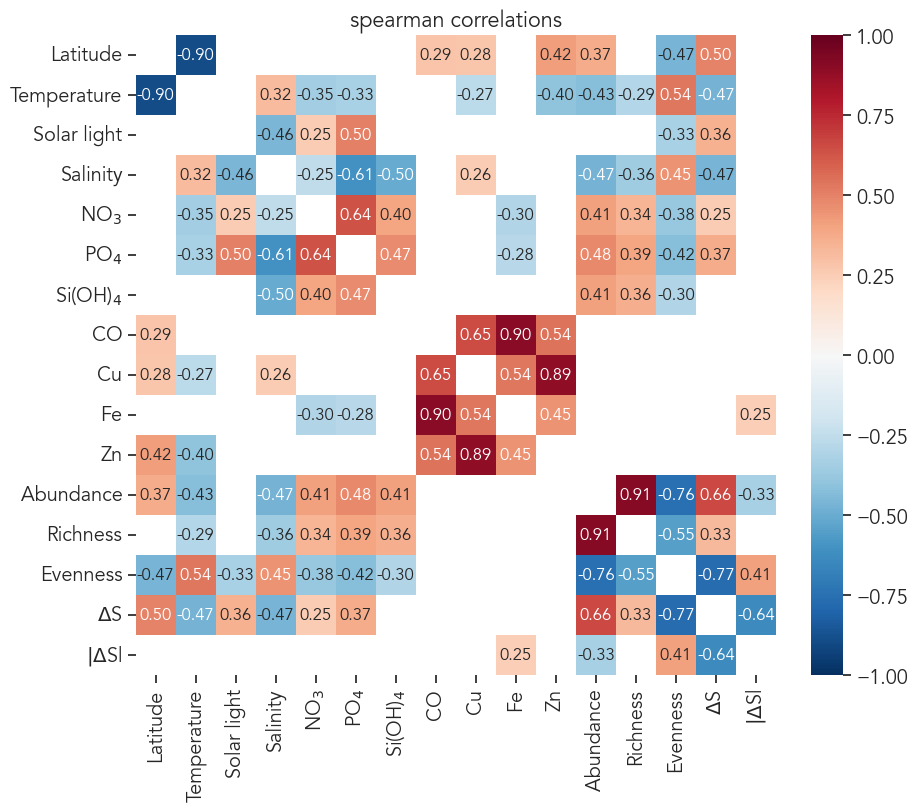

In [140]:
fig, ax = plt.subplots(figsize=(9,8), constrained_layout=True)

# mask pvalues < 0.01
mask = np.ones_like(corr)-np.diag(np.ones(len(corr)))
mask = (mask)*(pvalues_corr<1e-2).values

sns.heatmap(corr, annot=True, fmt = ".2f", mask = 1-mask, square=True, 
            annot_kws={"size": 12}, ax=ax, cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_title('{} correlations'.format(method))

for fig_format in fig_formats:
    fig.savefig(supfig_dir + 'figS8_correlations_{}'.format(method) + fig_format, dpi=300)

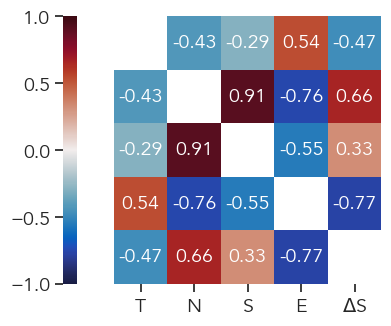

In [38]:
column_corr = ['temp_woa',  'TotAbundance_SRF','Richness_SRF', 'Evenness_SRF','DeltaS_asympt']
Corr_s = SRF.loc[:,column_corr].corr('spearman')
pvalues_corr_s = calculate_pvalues(SRF.loc[:,column_corr]) 

Corr_s.rename(columns={'Richness_SRF':'Richness', 'TotAbundance_SRF':'Abundance', 'Evenness_SRF':'Evenness', 'temp_woa':'Temperature', 'DeltaS_asympt':r'$\Delta$S'},
           index={'Richness_SRF':'Richness', 'TotAbundance_SRF':'Abundance', 'Evenness_SRF':'Evenness', 'temp_woa':'Temperature', 'DeltaS_asympt':r'$\Delta$S'},
            inplace=True
           )

Corr_s.head()

#mask = np.tril(np.ones_like(Corr.corr()))-np.diag(np.ones(5))
mask = np.ones_like(Corr_s.corr())-np.diag(np.ones(5))
#mask = (mask)*(pvalues<1e-2).values

fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)

sns.heatmap(data=Corr_s, ax=ax, 
            mask=1-mask,
            #annot=pvalues, fmt="1.1e",
            annot=True, fmt = ".2f",
           # mask = (pvalues<1e-3)*1.,
            annot_kws={"size": 14},
            vmax=1, vmin=-1,
            #ticklabels=['','','','',''],
            xticklabels=['T','N','S','E',r'$\Delta$S'],
            yticklabels=False,#['T','N','S','E',r'$\Delta$S'],
            square=True, cmap=cmocean.cm.balance,
            cbar_kws={ 'orientation': 'vertical', 'shrink': 1.,'pad':.08, 
                      'location':"left"
                     },
            #sns.color_palette("coolwarm", as_cmap=True)
           )

#fig.tight_layout()
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

for fig_format in fig_formats:
    fig.savefig(fig_dir + 'fig3a_correlations_{}'.format(method) + fig_format, dpi=300)


slope: -0.21394827647309894


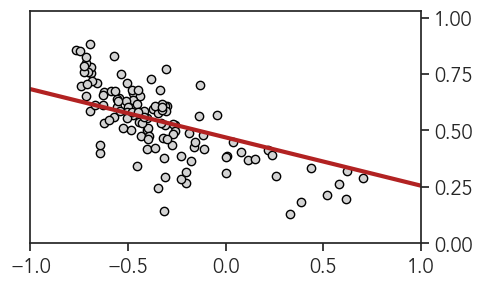

In [39]:
fig, ax = plt.subplots(figsize= (golden*8*cms,8*cms))

sns.scatterplot(data=SRF, 
                x='DeltaS_asympt', 
                y='Evenness_SRF', 
                ax=ax,
                edgecolor='black',
                linewidth=1,
                legend = False,
                color='lightgrey',
               )

ax.set(#xscale="log", yscale="log", 
    xlim=(-1, 1), 
    ylim=(-0.0,1.03), 
       xlabel='', 
       ylabel='',
    yticks = [0.0, 0.25, 0.5, 0.75, 1.]
      )

fit = linregress(x=SRF['DeltaS_asympt'],
                y=SRF['Evenness_SRF'])

print('slope: {}'.format(fit.slope))

x_axis = np.linspace(-1, 1)
y_axis = fit.intercept+fit.slope*x_axis
ax.plot(x_axis, y_axis, lw=3, ls='-', color='firebrick')

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.gca().yaxis.set_ticks_position('right')

fig.tight_layout()
plt.show()

for fig_format in fig_formats:
    fig.savefig(fig_dir + 'fig3b_DeltaS_vs_Evenness' + fig_format, dpi=300)


### S and DS vs T

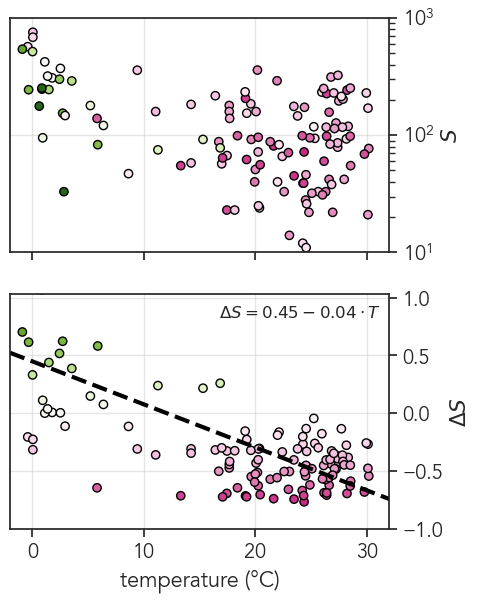

In [50]:
### S golden = (1 + 5 ** 0.5) / 2
cms = 0.393701
figsize = (golden*8*cms,16*cms)
fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)

ax = axes[0]
sns.scatterplot(data=SRF, 
                x='temp_woa', 
                y='Richness_SRF', 
                ax=ax,
                edgecolor='black',
                linewidth=1,
                hue ='DeltaS_asympt',
                hue_norm =clrs.Normalize(vmin=-1, vmax=1),
                legend = False,
                palette = "PiYG",
                #palette = sns.light_palette("grey", as_cmap=True)
                #palette = sns.color_palette("gray_r", as_cmap=True)
                color='lightgrey',
               )

#plt.colorbar(palette = sns.color_palette("gray_r", as_cmap=True), ax=ax)
ax.set(#xscale="log", yscale="log", 
       xlim=(-2, 32), 
       ylim=(1e1,1e3), 
       xlabel='temperature (°C)', 
       ylabel=r'$S$',
       yscale = 'log'
    #yticks = [0.0, 0.25, 0.5, 0.75, 1.]
      )

ax.grid(True, which='major', axis='both', alpha=0.5, zorder=0)

fit = linregress(x=SRF['temp_woa'],
                y=SRF['Richness_SRF'])

x_axis = np.linspace(-2, 32)
y_axis = fit.intercept+fit.slope*x_axis
label = r'$\Delta S = {:.2f} {:.2f} \cdot T$'.format(fit.intercept, fit.slope)
#ax.text(x=0.55, y=0.9, s=label, transform=ax.transAxes, fontsize=12)
#ax.text(x=0.55, y=0.8, s=r'$r^2 = {:.2f}$'.format(fit.rvalue**2), transform=ax.transAxes, fontsize=12)
#ax.plot(x_axis, y_axis, lw=3, ls='--', color='black', label=label)
#ax.legend(fontsize=12)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.gca().yaxis.set_ticks_position('right')

ax = axes[1]
sns.scatterplot(data=SRF, 
                x='temp_woa', 
                y='DeltaS_asympt', 
                ax=ax,
                edgecolor='black',
                linewidth=1,
                hue ='DeltaS_asympt',
                hue_norm = clrs.Normalize(vmin=-1, vmax=1),
                legend = False,
                palette = "PiYG",
                #palette = sns.light_palette("grey", as_cmap=True)
                #palette = sns.color_palette("gray_r", as_cmap=True)
                color='lightgrey',
               )

#plt.colorbar(palette = sns.color_palette("gray_r", as_cmap=True), ax=ax)
ax.set(#xscale="log", yscale="log", 
       xlim=(-2, 32), 
       ylim=(-1,1.03), 
       xlabel='temperature (°C)', 
       ylabel=r'$\Delta S$',
    #yticks = [0.0, 0.25, 0.5, 0.75, 1.]
      )

ax.grid(True, which='major', axis='both', alpha=0.5, zorder=0)

fit = linregress(x=SRF['temp_woa'],
                y=SRF['DeltaS_asympt'])

x_axis = np.linspace(-2, 32)
y_axis = fit.intercept+fit.slope*x_axis
label = r'$\Delta S = {:.2f} {:.2f} \cdot T$'.format(fit.intercept, fit.slope)
ax.text(x=0.55, y=0.9, s=label, transform=ax.transAxes, fontsize=12)
#ax.text(x=0.55, y=0.8, s=r'$r^2 = {:.2f}$'.format(fit.rvalue**2), transform=ax.transAxes, fontsize=12)
ax.plot(x_axis, y_axis, lw=3, ls='--', color='black', label=label)
#ax.legend(fontsize=12)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.gca().yaxis.set_ticks_position('right')

fig.tight_layout()
plt.show()
for fig_format in fig_formats:
    fig.savefig(supfig_dir + 'figS6_temp_vs_S' + fig_format, dpi=300)
#fig.savefig(fig_dir  + 'figSMrichnessT.png', facecolor='none', edgecolor='none')

### Insight on correlations

In [52]:
SRF.columns

Index(['station', 'latitude', 'longitude', 'depth_category', 'depth_nominal',
       'month', 'SSD', 'temp_woa', 'sal_woa', 'no3_woa', 'po4_woa',
       'sioh4_woa', 'dco', 'dcu', 'dfe', 'dzn', 'geometry', 'station_SRF',
       'TotAbundance_SRF', 'Richness_SRF', 'Shannon_SRF', 'Evenness_SRF',
       'region', 'lambda_SRF', 'alpha_SRF', 'beta_SRF', 'r_SRF', 'lambda_PL',
       'Spred_PL', 'DeltaS_PL', 'pval_PL', 'Spred_asympt', 'DeltaS_asympt',
       'pval_asympt', 'Spred_original', 'DeltaS_original', 'pval_original',
       'absolute_latitude', 'absolute_DS_asympt'],
      dtype='object')

SRF: r = -0.5575873142810305, p = 2.097823476691408e-11
fit. intercept: 6.061393323367933. slope: -2.7613500358244636


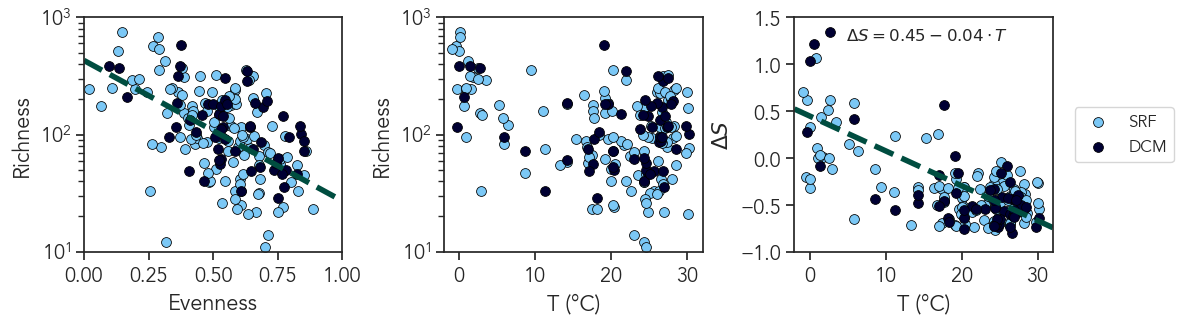

In [103]:
fig, axes = plt.subplots(1, 3, figsize=(figsize[0]*2.3, figsize[1]), constrained_layout=True, sharey=False)

# S vs E
ax = axes[0]
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Evenness')
ax.set_ylabel('Richness')

sns.scatterplot(x='Evenness_SRF', y='Richness_SRF', data=SRF, ax=ax, label='SRF', s=50, color=colorSRF, alpha=1, zorder=1, lw=0.1, edgecolor='black', legend=False)
r, p = pearsonr(SRF['Evenness_SRF'], SRF['Richness_SRF'])
print('SRF: r = {}, p = {}'.format(r, p))
sns.scatterplot(x='Evenness_DCM', y='Richness_DCM', data=DCM, ax=ax, s=50, label='DCM', color=colorDCM, alpha=1, zorder=1, lw=0.1, edgecolor='black', legend=False)
ax.set_ylim(1e1,1e3)
ax.set_xlim(0,1)

fit = linregress(x=SRF['Evenness_SRF'],
                  y=np.log(SRF['Richness_SRF']))
x = np.linspace(0,1)
y = np.exp(fit.intercept+fit.slope*x)
label = r'$r^2={:.2f}$'.format(fit.rvalue**2)
ax.plot(x, y, lw=4, ls='--', color='#004D40')
print('fit. intercept: {}. slope: {}'.format(fit.intercept, fit.slope))


# S vs T
ax = axes[1]
sns.scatterplot(x='temp_woa', y='Richness_SRF', data=SRF, ax=ax, label='SRF', s=50, color=colorSRF, alpha=1, zorder=1, lw=0.1, edgecolor='black', legend=False)
sns.scatterplot(x='temp_woa', y='Richness_DCM', data=DCM, ax=ax, s=50, label='DCM', color=colorDCM, alpha=1, zorder=1, lw=0.1, edgecolor='black', legend=False)

ax.set(#xscale="log", yscale="log", 
       xlim=(-2, 32), 
       ylim=(1e1,1e3), 
       xlabel='T (°C)', 
       ylabel='Richness',
       yscale = 'log'
      )

# Delta S vs T
ax = axes[2]
sns.scatterplot(x='temp_woa', y='DeltaS_asympt', data=SRF, ax=ax, label='SRF', s=50, color=colorSRF, alpha=1, zorder=1, lw=0.1, edgecolor='black')
sns.scatterplot(x='temp_woa', y='DeltaS_asympt', data=DCM, ax=ax, s=50, label='DCM', color=colorDCM, alpha=1, zorder=1, lw=0.1, edgecolor='black')
ax.set(#xscale="log", yscale="log", 
       xlim=(-2, 32), 
       ylim=(-1,1.5), 
       xlabel='T (°C)', 
       ylabel=r'$\Delta S$',
      )
ax.legend(fontsize=12, loc='center right', bbox_to_anchor=(1.5, 0.5))

fit = linregress(x=SRF['temp_woa'],
                y=SRF['DeltaS_asympt'])

x_axis = np.linspace(-2, 32)
y_axis = fit.intercept+fit.slope*x_axis
label = r'$\Delta S = {:.2f} {:.2f} \cdot T$'.format(fit.intercept, fit.slope)
ax.text(x=0.2, y=0.9, s=label, transform=ax.transAxes, fontsize=12)
ax.plot(x_axis, y_axis, lw=4, ls='--', color='#004D40', label=label)

for fig_format in fig_formats:
    fig.savefig(supfig_dir + 'figS7_SvsT' + fig_format, dpi=300)


## K meta-community index

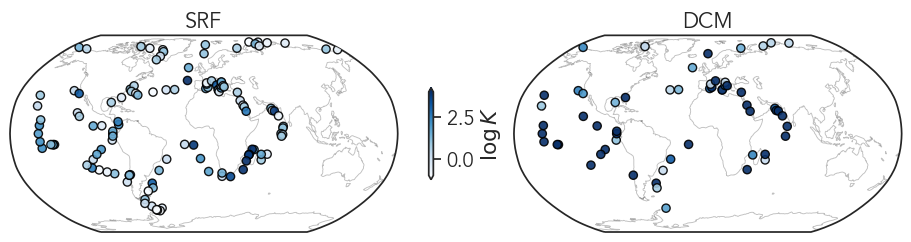

In [138]:
K_SRF = SRF['Richness_SRF']/SRF['TotAbundance_SRF']**(SRF['lambda_SRF']-1)
SRF['K_SRF'] = np.log(K_SRF)
K_DCM = DCM['Richness_DCM']/DCM['TotAbundance_DCM']**(DCM['lambda_DCM']-1)
DCM['K_DCM'] = K_DCM

fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.Robinson()}, figsize=(9,2.5), constrained_layout=True)
ax = axes[0]
ax.set_title('SRF')
ax.set_global()
ax.coastlines(alpha=0.25,lw=0.65)

cmap = "Blues"
cbar = SRF.plot(column='K_SRF', cmap=cmap, transform = ccrs.Geodetic(), ax=ax, zorder=10, vmin = -1., vmax = 4,
         legend=True, alpha=0.9, lw=1, edgecolors='black', s=35, 
                 legend_kwds={'shrink': 0.4, 'pad':0.08, #'ticks':ticks,# 'set_yticklabels':ticks_labels,
                      'orientation': 'vertical', 
                      'extend':'both', "fmt": "{:1.0e}",
                      'label': r'$\log{K}$'
                     })

ax = axes[1]
ax.set_global()
ax.set_title('DCM')
ax.coastlines(alpha=0.25,lw=0.65)
cbar = DCM.plot(column='K_DCM', cmap=cmap, transform = ccrs.Geodetic(), ax=ax, zorder=10, vmin = -1., vmax = 4,
         legend=False, alpha=0.9, lw=1, edgecolors='black', s=35, 
                 legend_kwds={'shrink': 0.4, 'pad':0.08, #'ticks':ticks,# 'set_yticklabels':ticks_labels,
                      'orientation': 'vertical', 
                      'extend':'both', "fmt": "{:1.0e}",
                      'label': r'$\log{K}$'
                     })

for fig_format in fig_formats:
    fig.savefig(supfig_dir + 'figS6_K' + fig_format, dpi=300)

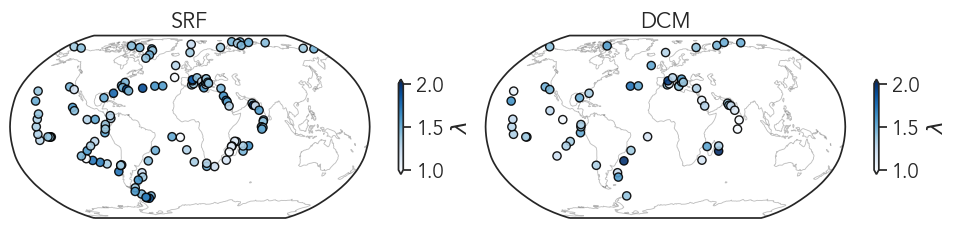

In [157]:
fig, axes = plt.subplots(1,2, subplot_kw={'projection':  ccrs.Robinson()}, figsize=(9.5,2.5), constrained_layout=True)

ax = axes[0]
ax.set_title('SRF')
ax.set_global()
ax.coastlines(alpha=0.25,lw=0.65)

cmap = "Blues"
cbar = SRF.plot(column='lambda_SRF', cmap=cmap, transform = ccrs.Geodetic(), ax=ax, zorder=10, vmin = 1., vmax = 2.,
         legend=True, alpha=0.9, lw=1, edgecolors='black', s=35, 
                 legend_kwds={'shrink': 0.4, 'pad':0.08, #'ticks':ticks,# 'set_yticklabels':ticks_labels,
                      'orientation': 'vertical', 
                      'extend':'both', "fmt": "{:1.0e}",
                      'label': r'$\lambda$'
                     })

ax = axes[1]
ax.set_title('DCM')
ax.set_global()
ax.coastlines(alpha=0.25,lw=0.65)

cmap = "Blues"
cbar = DCM.plot(column='lambda_DCM', cmap=cmap, transform = ccrs.Geodetic(), ax=ax, zorder=10, vmin = 1., vmax = 2.,
         legend=True, alpha=0.9, lw=1, edgecolors='black', s=35, 
                 legend_kwds={'shrink': 0.4, 'pad':0.08, #'ticks':ticks,# 'set_yticklabels':ticks_labels,
                      'orientation': 'vertical', 
                      'extend':'both', "fmt": "{:1.0e}",
                      'label': r'$\lambda$'
                     })

for fig_format in fig_formats:
    fig.savefig(supfig_dir + 'figS10_lambdafit' + fig_format, dpi=300)


## Da ordinare

In [191]:
import numpy as np
from scipy.stats import zipf

In [240]:
S = 1000
species = range(S)
 
# Log-Series distributed population
theta = 0.99999
population_logseries = np.random.logseries(theta, S)

# Zipf distributed population
alpha = 0.5
u = 1-np.random.uniform(size=S)
population_zipf = np.array((1-u/alpha)**(-1./(alpha)), dtype=int)

print('Log-series: {}'.format(np.sum(population_logseries)))
print('Zipf: {}'.format(np.sum(population_zipf)))

Log-series: 8129932
Zipf: 8149646


In [247]:
species = range(S)

In [243]:
# store the results in pickle files
with open('../data/population_logseries.pkl', 'wb') as f:
    pickle.dump(population_logseries, f)
    
with open('../data/population_zipf.pkl', 'wb') as f:
    pickle.dump(population_zipf, f)

In [267]:
# generate subsamples from theses populations

ps = np.logspace(-6, -1, 6)
samples = [None] * len(ps)

for p in ps:
    Np = int(np.sum(population_logseries) * p)
    print('p = {}; Np = {}'.format(p, Np))
    subsample = np.zeros(Np, dtype=int)
    probabilities = np.copy(population_logseries)
    for i in tqdm(range(Np)):
        species_extracted = np.random.choice(species, size=1, p=probabilities/probabilities.sum())[0]
        subsample[i] = species_extracted
        probabilities[species_extracted] -= 1
        
    _, counts = np.unique(subsample, return_counts=True)
    samples.append(counts)
    
# store the results in pickle files
with open('../data/samples_logseries.pkl', 'wb') as f:
    pickle.dump(samples, f)

p = 1e-06; Np = 8


100%|██████████| 8/8 [00:00<00:00, 5472.02it/s]


p = 1e-05; Np = 81


100%|██████████| 81/81 [00:00<00:00, 7251.62it/s]


p = 0.0001; Np = 812


100%|██████████| 812/812 [00:00<00:00, 10133.16it/s]


p = 0.001; Np = 8129


100%|██████████| 8129/8129 [00:00<00:00, 10661.72it/s]


p = 0.01; Np = 81299


100%|██████████| 81299/81299 [00:07<00:00, 10752.48it/s]


p = 0.1; Np = 812993


100%|██████████| 812993/812993 [01:15<00:00, 10702.93it/s]


In [268]:
# generate subsamples from theses populations

ps = np.logspace(-6, -1, 6)
samples = [None] * len(ps)

for p in ps:
    Np = int(np.sum(population_zipf) * p)
    print('p = {}; Np = {}'.format(p, Np))
    subsample = np.zeros(Np, dtype=int)
    probabilities = np.copy(population_zipf)
    for i in tqdm(range(Np)):
        species_extracted = np.random.choice(species, size=1, p=probabilities/probabilities.sum())[0]
        subsample[i] = species_extracted
        probabilities[species_extracted] -= 1
        
    _, counts = np.unique(subsample, return_counts=True)
    samples.append(counts)
    
# store the results in pickle files
with open('../data/samples_zipf.pkl', 'wb') as f:
    pickle.dump(samples, f)

p = 1e-06; Np = 8


100%|██████████| 8/8 [00:00<00:00, 4266.30it/s]


p = 1e-05; Np = 81


100%|██████████| 81/81 [00:00<00:00, 9038.97it/s]


p = 0.0001; Np = 814


100%|██████████| 814/814 [00:00<00:00, 10348.99it/s]


p = 0.001; Np = 8149


100%|██████████| 8149/8149 [00:00<00:00, 10819.20it/s]


p = 0.01; Np = 81496


100%|██████████| 81496/81496 [00:07<00:00, 10874.90it/s]


p = 0.1; Np = 814964


100%|██████████| 814964/814964 [01:14<00:00, 10869.20it/s]


In [269]:
# read the results from pickle files

samples_logseries = pickle.load(open('../data/samples_logseries.pkl', 'rb'))
samples_zipf = pickle.load(open('../data/samples_zipf.pkl', 'rb'))

In [305]:
S_logseries = [np.sum(sample>0) for sample in samples_logseries if sample is not None]
S_zipf = [np.sum(sample>0) for sample in samples_zipf if sample is not None]
N_logseries = [np.sum(sample) for sample in samples_logseries if sample is not None]
N_zipf = [np.sum(sample) for sample in samples_zipf if sample is not None]
relative_logseries = [sample/np.sum(population_logseries) for sample in samples_logseries if sample is not None]
relative_zipf = [sample/np.sum(population_zipf) for sample in samples_zipf if sample is not None]

def evenness(sample):
    if len(sample) <= 1:
        return 0
    else:
        return -np.sum(sample*np.log(sample))/np.log(len(sample))

evenness_logseries = [evenness(sample) for sample in relative_logseries]
evenness_zipf = [evenness(sample) for sample in relative_zipf]

<Axes: >

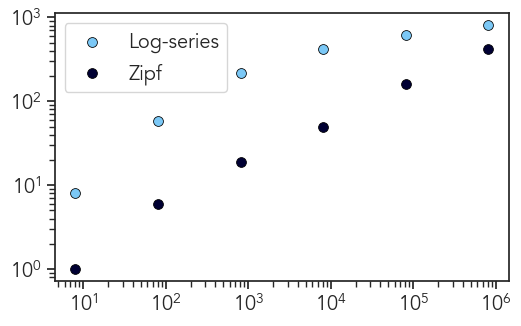

In [290]:
fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
ax.set_xscale('log')
ax.set_yscale('log')

sns.scatterplot(x=N_logseries, y=S_logseries, ax=ax, s=50, color=colorSRF, alpha=1, zorder=1, lw=0.1, edgecolor='black', label='Log-series')
sns.scatterplot(x=N_zipf, y=S_zipf, ax=ax, s=50, color=colorDCM, alpha=1, zorder=1, lw=0.1, edgecolor='black', label='Zipf')

<Axes: >

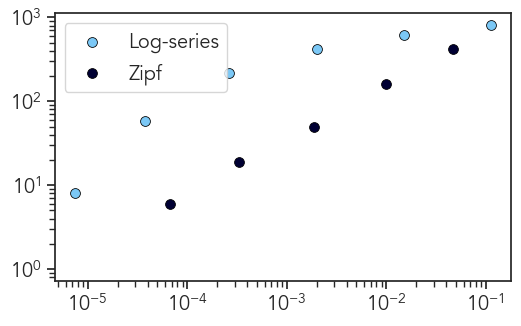

In [308]:
fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
ax.set_xscale('log')
ax.set_yscale('log')

sns.scatterplot(x=evenness_logseries, y=S_logseries, ax=ax, s=50, color=colorSRF, alpha=1, zorder=1, lw=0.1, edgecolor='black', label='Log-series')
sns.scatterplot(x=evenness_zipf, y=S_zipf, ax=ax, s=50, color=colorDCM, alpha=1, zorder=1, lw=0.1, edgecolor='black', label='Zipf')

<Axes: >

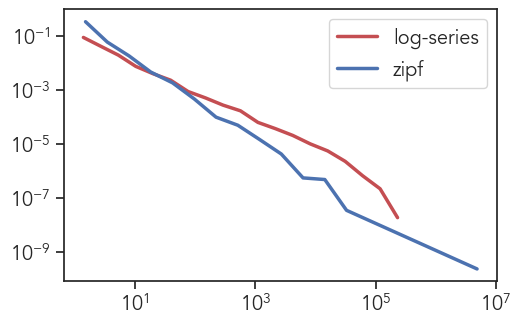

In [242]:
fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
ax.set_xscale('log')
ax.set_yscale('log')

# log histogram of log-series population
bins, counts, prob, pdf = log_hist(population_logseries, nbins=20)
x = np.sqrt(bins[:-1]*bins[1:])
y = pdf
x = x[y>0]
y = y[y>0]
sns.lineplot(x=x, y=y, ax=ax, lw=2.5, ls='-', alpha=1, zorder=1, color='r', label='log-series')

# log histogram of zipf population
bins, counts, prob, pdf = log_hist(population_zipf, nbins=20)
x = np.sqrt(bins[:-1]*bins[1:])
y = pdf
x = x[y>0]
y = y[y>0]
sns.lineplot(x=x, y=y, ax=ax, lw=2.5, ls='-', alpha=1, zorder=1, color='b', label='zipf')

In [333]:
Ss = np.logspace(2, 6, 10, dtype=int)
evenness_logseries = {}
evenness_zipf = {}
Nreplica = 500

for S in Ss:
    species = range(S)
 
    # Log-Series distributed population
    theta = 0.99999
    ev = []
    for i in range(Nreplica):
        population_logseries = np.random.logseries(theta, S)
        # compute evenness
        ev.append(evenness(population_logseries/np.sum(population_logseries)))
    
    # compute evenness
    evenness_logseries[S] = np.array(ev)
    

    # Zipf distributed population
    alpha = 0.5
    ev = []
    for i in range(Nreplica):
        u = 1-np.random.uniform(size=S)
        population_zipf = np.array((1-u/alpha)**(-1./(alpha)), dtype=int)
        # compute evenness
        ev.append(evenness(population_zipf/np.sum(population_zipf)))
    # compute evenness
    evenness_zipf[S] = np.array(ev)

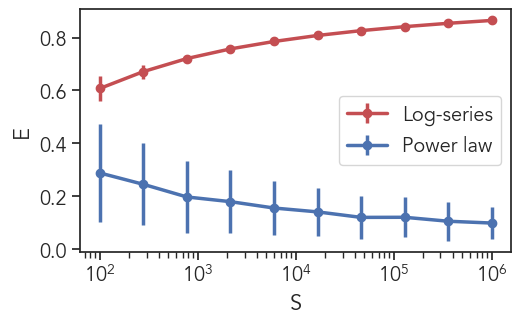

In [335]:
fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)

x = np.array(list(evenness_logseries.keys()))
y = np.array(list(evenness_logseries.values())).mean(axis=1)
yerr = np.array(list(evenness_logseries.values())).std(axis=1)
#sns.lineplot(x=x, y=y, ax=ax, lw=2.5, ls='-', alpha=1, zorder=1, color='r', label='Log-series')
#ax.fill_between(x, y-yerr, y+yerr, color='r', alpha=0.2)
ax.errorbar(x, y, yerr, color='r', alpha=1, fmt='-o', lw=2.5, label='Log-series')
x = np.array(list(evenness_zipf.keys()))
y = np.array(list(evenness_zipf.values())).mean(axis=1)
yerr = np.array(list(evenness_zipf.values())).std(axis=1)
#sns.scatterplot(x=x, y=y, ax=ax, lw=2.5, ls='-', alpha=1, zorder=1, color='b', label='Power law')

ax.errorbar(x, y, yerr, color='b', alpha=1, fmt='-o', lw=2.5, label='Power law')

ax.set_xscale('log')

ax.set_xlabel('S')
ax.set_ylabel('E')
ax.legend()

for fig_format in fig_formats:
    fig.savefig(supfig_dir + 'S_E_PLvsLS' + fig_format, dpi=300)

In [ ]:
# generate a population distributed according to log-series distribution
S = 1000
species = range(S)
alpha = 0.5
u = 1-np.random.uniform(size=S)
x = np.array((1-u/alpha)**(-1./(alpha)), dtype=int)
N = np.sum(x)
